In [112]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import dill
import copy
import numpy as np
from scipy.stats import sem
from scipy.stats import sem
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["axes.xmargin"] = 0
import matplotlib

matplotlib.rcParams["mathtext.fontset"] = "cm"

In [113]:
# !pip install scipy

In [114]:
def get_sweeps(project):
    sweeps = []
    for sweep in project:
        sweeps.append((sweep.name, sweep.id))
    return sweeps[::-1]


def get_run_links(sweeps, project_name):
    runs = []
    for sweep_name, sweep_link in sweeps:
        sweep = wandb.Api().sweep(f"lucacorbucci/{project_name}/{sweep_link}")
        run_list_sweep = []
        for run in sweep.runs:
            run_list_sweep.append(run.id)
        runs.append((sweep_name, run_list_sweep[::-1]))
    return runs


def get_run_data(run_links_per_sweep, project_name):
    run_data = []
    for sweep_name, sweep in run_links_per_sweep:
        print("Downloading data for a sweep")
        tmp_run_data = []
        for run_link in sweep:
            run = wandb.Api().run(f"lucacorbucci/{project_name}/{run_link}")

            tmp_run_data.append(pd.DataFrame(run.scan_history()))
        run_data.append((sweep_name, tmp_run_data))
    return run_data


def remove_nan(column_names, dataframe):
    column_names = [
        column_name for column_name in column_names if column_name in dataframe.columns
    ]

    current_df = dataframe[column_names]
    # consider each column in training_data_disparity independently and
    # remove the rows where we have NaN
    new_columns = []

    for column in current_df.columns:
        new_values = list(current_df[column].dropna())
        new_columns.append(new_values)

    # if the lists have different lengths, we need to modify them so that
    # we have the same length:
    min_size = min([len(item) for item in new_columns])
    new_columns = [item[:min_size] for item in new_columns]

    # create the new dataframe with baseline_test_nodes_columns_disparity_dataset as columns
    # names and new_columns as values
    new_df = pd.DataFrame(dict(zip(column_names, new_columns)))
    return new_df


def create_avg_dataset(new_list):
    # print(new_list)
    # compute the mean and the std of the data in new_list
    # and create a new dataset with these values
    mean = []
    std = []
    dots_lenght = len(new_list[0])
    for dots in range(dots_lenght):
        current_values = []
        for item in new_list:
            if item[dots] > 0:
                current_values.append(item[dots])
        current_mean = np.mean(current_values)
        mean.append(current_mean)
        current_std = np.std(current_values, axis=0)  # sem(current_values)
        std.append(current_std)
    # std = sem(new_list)  # np.std(new_list, axis=0)

    df = pd.DataFrame()
    dots_list = []
    increasing_mean = []
    current_max = 0
    new_std = []
    previous_std = -1
    previous_mean = -1
    for value_mean, value_std in zip(mean, std):
        if value_mean > current_max:
            current_max = value_mean
            dots_list.append(current_max)
        else:
            dots_list.append(None)

        if value_mean >= previous_mean:
            new_std.append(value_std)
            increasing_mean.append(value_mean)
            previous_mean = value_mean
            previous_std = value_std
        else:
            new_std.append(previous_std)
            increasing_mean.append(previous_mean)

    df["mean"] = increasing_mean  # mean
    df["dots"] = dots_list
    df["std"] = new_std  # std
    df["index"] = list(range(0, len(mean)))
    return df


def prepare_pareto_frontier(data_lists):
    custom_metrics = []

    for data_list in data_lists:
        tmp_custom_metrics = []
        current_max = 0
        for value in data_list:
            if value >= current_max:
                current_max = value
            tmp_custom_metrics.append(current_max)
        custom_metrics.append(copy.deepcopy(tmp_custom_metrics))

    return custom_metrics


def extract_last_custom_metrics(sweep, expected_len):
    custom_metrics = []
    for sweep_dfs in sweep:
        tmp_custom_metrics = []
        for df in sweep_dfs:
            custom_metric = remove_nan(["Custom_metric"], df)
            last_value = custom_metric.values.tolist()[-1][0]
            if last_value == "-Infinity":
                last_value = 0
            if len(custom_metric) != expected_len:
                last_value = 0
            tmp_custom_metrics.append(last_value)
        custom_metrics.append(tmp_custom_metrics)
    return custom_metrics


# Functions to plot
def plot_pareto_frontier(mean_df_tunable, mean_df_fixed, name, target, epsilon):
    plt.figure(figsize=(15, 10))

    # Plot mean as a line
    plt.plot(
        mean_df_tunable["index"],
        mean_df_tunable["mean"],
        label="Tunable Lambda",
        color="blue",
    )
    plt.plot(
        mean_df_fixed["index"],
        mean_df_fixed["mean"],
        label="Fixed Lambda",
        color="green",
    )

    # Plot dots for non-None values in "dots" column
    dots_mask = mean_df_tunable["dots"].notnull()
    plt.scatter(
        mean_df_tunable["index"][dots_mask],
        mean_df_tunable["dots"][dots_mask],
        color="blue",
        marker="o",
    )

    dots_mask = mean_df_fixed["dots"].notnull()
    plt.scatter(
        mean_df_fixed["index"][dots_mask],
        mean_df_fixed["dots"][dots_mask],
        color="green",
        marker="o",
    )

    # Plot std as shaded area
    plt.fill_between(
        mean_df_tunable["index"],
        mean_df_tunable["mean"] - mean_df_tunable["std"],
        mean_df_tunable["mean"] + mean_df_tunable["std"],
        alpha=0.2,
        color="blue",
    )

    plt.fill_between(
        mean_df_fixed["index"],
        mean_df_fixed["mean"] - mean_df_fixed["std"],
        mean_df_fixed["mean"] + mean_df_fixed["std"],
        alpha=0.2,
        color="green",
    )

    # Customize the plot
    plt.title(rf"Fixed vs Tunable - Target {target} - \epsilon {epsilon}")
    plt.xlabel("Experiments")
    plt.ylabel("Maximixed Metric")
    plt.rcParams.update({"font.size": 35})
    plt.ylim(0, 1)
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()

    plt.savefig(f"./plots_paper/Dutch/{name}_std.png")
    plt.show()


def plot(project_name):
    project = wandb.Api().project(project_name).sweeps()
    sweeps = get_sweeps(project)
    run_links = get_run_links(sweeps, project_name)
    data = get_run_data(
        run_links,
        project_name,
    )
    tunable = [df for name, df in data if name == "prob_tunable_private"]
    fixed = [df for name, df in data if name == "prob_fixed_private"]
    custom_metrics_tunable = extract_last_custom_metrics(tunable)
    custom_metrics_fixed = extract_last_custom_metrics(fixed)
    pareto_list_tunable = prepare_pareto_frontier(custom_metrics_tunable)
    pareto_list_fixed = prepare_pareto_frontier(custom_metrics_fixed)
    df_pareto_tunable = create_avg_dataset(pareto_list_tunable)
    df_pareto_fixed = create_avg_dataset(pareto_list_fixed)
    plot_pareto_frontier(df_pareto_tunable, df_pareto_fixed, project_name)


def prepare_mean_and_std(
    no_dp_experiments,
    tunable_experiments,
    fixed_experiments,
    baseline_experiments,
    accuracy_experiments_type="Train",
    disparity_experiments_type="Training",
):
    tunable_train_accuracy = []
    tunable_train_disparity = []
    for experiment in tunable_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        tunable_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        tunable_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    fixed_train_accuracy = []
    fixed_train_disparity = []
    for experiment in fixed_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        fixed_train_accuracy.append(list(experiment[accuracy_experiments_type])[0:40])
        fixed_train_disparity.append(list(experiment[disparity_experiments_type])[0:40])

    fixed_mean_train_accuracy = np.mean(fixed_train_accuracy, axis=0)
    fixed_mean_train_disparity = np.mean(fixed_train_disparity, axis=0)
    if len(fixed_train_accuracy) > 1:
        fixed_std_train_accuracy = sem(
            fixed_train_accuracy
        )  # np.std(fixed_train_accuracy, axis=0)
        fixed_std_train_disparity = sem(
            fixed_train_disparity
        )  # np.std(fixed_train_disparity, axis=0)
    else:
        fixed_std_train_accuracy = fixed_train_accuracy
        fixed_std_train_disparity = fixed_train_disparity

    # for item in tunable_train_accuracy:
    #     print(len(item))
    tunable_mean_train_accuracy = np.mean(tunable_train_accuracy, axis=0)
    tunable_mean_train_disparity = np.mean(tunable_train_disparity, axis=0)
    if len(tunable_train_accuracy) > 1:
        tunable_std_train_accuracy = sem(
            tunable_train_accuracy
        )  # np.std(tunable_train_accuracy, axis=0)
        tunable_std_train_disparity = sem(
            tunable_train_disparity
        )  # np.std(tunable_train_disparity, axis=0)
    else:
        tunable_std_train_accuracy = tunable_train_accuracy
        tunable_std_train_disparity = tunable_train_disparity

    baseline_train_accuracy = []
    baseline_train_disparity = []
    for experiment in baseline_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        baseline_train_accuracy.append(
            list(experiment[accuracy_experiments_type])[0:40]
        )
        baseline_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    no_dp_train_accuracy = []
    no_dp_train_disparity = []
    for experiment in no_dp_experiments:
        experiment = remove_nan(
            [
                accuracy_experiments_type,
                disparity_experiments_type,
            ],
            experiment,
        )
        no_dp_train_accuracy.append(
            list(experiment[accuracy_experiments_type])[0:40]
        )
        no_dp_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    baseline_mean_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_mean_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    baseline_std_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    if len(baseline_experiments) > 0:
        baseline_mean_train_accuracy = np.mean(baseline_train_accuracy, axis=0)
        baseline_mean_train_disparity = np.mean(baseline_train_disparity, axis=0)

        if len(baseline_train_disparity) > 1:
            baseline_std_train_disparity = sem(
                baseline_train_disparity
            )  # np.std(baseline_train_disparity, axis=0)
        else:
            baseline_std_train_disparity = baseline_mean_train_disparity
        if len(baseline_train_accuracy) > 1:
            baseline_std_train_accuracy = sem(
                baseline_train_accuracy
            )  # np.std(baseline_train_accuracy, axis=0)
        else:
            baseline_std_train_accuracy = baseline_mean_train_accuracy

    no_dp_mean_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    no_dp_mean_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    no_dp_std_train_accuracy = np.array([0] * len(tunable_std_train_accuracy))
    no_dp_std_train_disparity = np.array([0] * len(tunable_std_train_accuracy))
    if len(no_dp_experiments) > 0:
        no_dp_mean_train_accuracy = np.mean(no_dp_train_accuracy, axis=0)
        no_dp_mean_train_disparity = np.mean(no_dp_train_disparity, axis=0)

        if len(no_dp_train_disparity) > 1:
            no_dp_std_train_disparity = sem(
                no_dp_train_disparity
            )  # np.std(baseline_train_disparity, axis=0)
        else:
            no_dp_std_train_disparity = no_dp_mean_train_disparity
        if len(no_dp_train_accuracy) > 1:
            no_dp_std_train_accuracy = sem(
                no_dp_train_accuracy
            )  # np.std(baseline_train_accuracy, axis=0)
        else:
            no_dp_std_train_accuracy = no_dp_mean_train_accuracy


    return (
        no_dp_mean_train_accuracy, 
        no_dp_mean_train_disparity,
        no_dp_std_train_accuracy,
        no_dp_std_train_disparity,
        baseline_mean_train_accuracy,
        baseline_mean_train_disparity,
        baseline_std_train_accuracy,
        baseline_std_train_disparity,
        fixed_mean_train_accuracy,
        fixed_mean_train_disparity,
        fixed_std_train_accuracy,
        fixed_std_train_disparity,
        tunable_mean_train_accuracy,
        tunable_mean_train_disparity,
        tunable_std_train_accuracy,
        tunable_std_train_disparity,
    )


def prepare_mean_and_std_no_dp(
    tunable_experiments,
    fixed_experiments,
    disparity_experiments_type
):
    
    tunable_train_disparity = []
    for experiment in tunable_experiments:
        experiment = remove_nan(
            [
                disparity_experiments_type,
            ],
            experiment,
        )
        tunable_train_disparity.append(
            list(experiment[disparity_experiments_type])[0:40]
        )

    
    fixed_train_disparity = []
    for experiment in fixed_experiments:
        experiment = remove_nan(
            [
                disparity_experiments_type,
            ],
            experiment,
        )
        fixed_train_disparity.append(list(experiment[disparity_experiments_type])[0:40])

    fixed_mean_train_disparity = np.mean(fixed_train_disparity, axis=0)
    fixed_std_train_disparity = sem(
            fixed_train_disparity
        )
    

    tunable_mean_train_disparity = np.mean(tunable_train_disparity, axis=0)
    tunable_std_train_disparity = sem(
            tunable_train_disparity
        )
    print(fixed_std_train_disparity)
    print(tunable_std_train_disparity)
    return (
        fixed_mean_train_disparity,
        fixed_std_train_disparity,
        tunable_mean_train_disparity,
        tunable_std_train_disparity,
    )

def plot_accuracy(
    no_dp_mean_train_accuracy, 
    no_dp_std_train_accuracy,
    tunable_mean_train_accuracy,
    tunable_std_train_accuracy,
    fixed_mean_train_accuracy,
    fixed_std_train_accuracy,
    baseline_mean_train_accuracy,
    baseline_std_train_accuracy,
    experiment_name,
    target,
    epsilon,
    experiment_type="Train",
    num_rounds=10,
    std=True,
    file_name="",
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    if not (no_dp_mean_train_accuracy == 0).all():
        line_1, = plt.plot(
            x,
            no_dp_mean_train_accuracy,
            label="Baseline",
            color="black",
            linewidth=3,
            linestyle="dashdot",
        )
    if not (baseline_mean_train_accuracy == 0).all():
        line_2, = plt.plot(
            x,
            baseline_mean_train_accuracy,
            label="DP",
            color="red",
            linewidth=3,
        )

    
    line_3, = plt.plot(
        x,
        tunable_mean_train_accuracy,
        label="DP+Fair (Tunable $\lambda$)",
        color="blue",
        linewidth=3,
        linestyle="dotted",
    )
    line_4, = plt.plot(
        x,
        fixed_mean_train_accuracy,
        label="DP+Fair (Fixed $\lambda$)",
        color="green",
        linewidth=3,
        linestyle="dashed",
    )


    # legendFig = plt.figure("Legend plot")
    # legendFig.legend([line_1, line_2, line_3, line_4], ["Baseline", "DP", "DP+Fair (Tunable $\lambda$)", "DP+Fair (Fixed $\lambda$)"], ncol=4, fontsize="30")
    # legendFig.savefig('legend_accuracy.png', bbox_inches='tight')

    

    # compare the two numpy arrays with all the values
    if std and not (baseline_mean_train_accuracy == baseline_std_train_accuracy).all():
        plt.fill_between(
            x,
            baseline_mean_train_accuracy - baseline_std_train_accuracy,
            baseline_mean_train_accuracy + baseline_std_train_accuracy,
            alpha=0.2,
            color="red",
        )
    if std and not (no_dp_mean_train_accuracy == no_dp_std_train_accuracy).all():
        plt.fill_between(
            x,
            no_dp_mean_train_accuracy - no_dp_std_train_accuracy,
            no_dp_mean_train_accuracy + no_dp_std_train_accuracy,
            alpha=0.2,
            color="black",
        )


    if std and not (tunable_mean_train_accuracy == tunable_std_train_accuracy).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_accuracy - tunable_std_train_accuracy,
            tunable_mean_train_accuracy + tunable_std_train_accuracy,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_accuracy == fixed_std_train_accuracy).all():
        plt.fill_between(
            x,
            fixed_mean_train_accuracy - fixed_std_train_accuracy,
            fixed_mean_train_accuracy + fixed_std_train_accuracy,
            alpha=0.2,
            color="green",
        )

    plt.ylim(0.7, 0.8)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 35})

    plt.ylabel("Accuracy")
    plt.title(
        f"Test Accuracy"
        # + ("- Mean & Std. Err." if std else "")
        + rf" - Tar. {target} - Eps. {epsilon}"
    )
    # plt.legend(ncol=2)
    plt.grid(True)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f"./plots_paper/Income/accuracy_{file_name}.png", bbox_inches='tight')

    plt.show()


def plot_disparity(
    no_dp_mean_train_disparity,
    no_dp_std_train_disparity,
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    baseline_mean_train_disparity,
    baseline_std_train_disparity,
    experiment_name,
    target,
    epsilon,
    experiment_type,
    num_rounds=10,
    std=True,
    file_name="",
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    if not (no_dp_mean_train_disparity == 0).all():
        line_1, = plt.plot(
            x,
            no_dp_mean_train_disparity,
            label="Baseline",
            color="black",
            linewidth=3,
            linestyle="dashdot",
        )

    if not (baseline_mean_train_disparity == 0).all():
        line_2, = plt.plot(
            x,
            baseline_mean_train_disparity,
            label="DP",
            color="red",
            linewidth=3,
        )
    
    line_3, = plt.plot(
        x,
        tunable_mean_train_disparity,
        label="DP+Fair (Tunable $\lambda$)",
        color="blue",
        linewidth=3,
        linestyle="dotted",
    )
    line_4, = plt.plot(
        x,
        fixed_mean_train_disparity,
        label="DP+Fair (Fixed $\lambda$)",
        color="green",
        linewidth=3,
        linestyle="dashed",
    )
    
    if (
        std
        and not (baseline_mean_train_disparity == baseline_std_train_disparity).all()
    ):
        plt.fill_between(
            x,
            baseline_mean_train_disparity - baseline_std_train_disparity,
            baseline_mean_train_disparity + baseline_std_train_disparity,
            alpha=0.2,
            color="red",
        )
    
    if (
        std
        and not (no_dp_mean_train_disparity == no_dp_std_train_disparity).all()
    ):
        plt.fill_between(
            x,
            no_dp_mean_train_disparity - no_dp_std_train_disparity,
            no_dp_mean_train_disparity + no_dp_std_train_disparity,
            alpha=0.2,
            color="black",
        )
    if std and not (tunable_mean_train_disparity == tunable_std_train_disparity).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_disparity - tunable_std_train_disparity,
            tunable_mean_train_disparity + tunable_std_train_disparity,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_disparity == fixed_std_train_disparity).all():
        plt.fill_between(
            x,
            fixed_mean_train_disparity - fixed_std_train_disparity,
            fixed_mean_train_disparity + fixed_std_train_disparity,
            alpha=0.2,
            color="green",
        )

    # horizontal line indicating the target between 0 and num-rounds
    line_5 = plt.axhline(
        y=target,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
        xmin=0,
        xmax=num_rounds,
    )
    plt.ylim(0, 0.3)

    

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 35})

    plt.ylabel("Disparity")
    plt.title(
        f"Test Disparity"
        # + ("- Mean & Std. Err." if std else "")
        + f" - Tar. {target} - "
        #        + r'$\mathrm{\epsilon}$'
        + f"Eps. {epsilon}",
        fontsize=35,
    )
    #plt.legend(ncol=2, fontsize="30")
    plt.grid(True)

    # Show the plot
    plt.tight_layout()

    plt.savefig(f"./plots_paper/Income/disparity_{file_name}.png",bbox_inches='tight')
    plt.show()
    legendFig = plt.figure("Legend plot")
    legendFig.legend([line_1, line_2, line_3, line_4, line_5], ["Baseline", "DP", "DP+Fair (Tunable $\lambda$)", "DP+Fair (Fixed $\lambda$)", "Target"], ncol=5, fontsize="30")
    legendFig.savefig('legend_disparity.png', bbox_inches='tight')


def plot_disparity_no_dp(
    tunable_mean_train_disparity,
    tunable_std_train_disparity,
    fixed_mean_train_disparity,
    fixed_std_train_disparity,
    experiment_name,
    target,
    experiment_type,
    num_rounds=10,
    std=True,
    file_name="",
):
    # plot train accuracy with fixed and tunable lambda and std
    # Plotting the mean values over time
    plt.figure(figsize=(15, 10))

    x = list(range(0, num_rounds))
    
    
    plt.plot(
        x,
        tunable_mean_train_disparity,
        label="DP+Fair (Tunable $\lambda$)",
        color="blue",
        linewidth=3,
        linestyle="dotted",
    )
    plt.plot(
        x,
        fixed_mean_train_disparity,
        label="DP+Fair (Fixed $\lambda$)",
        color="green",
        linewidth=3,
        linestyle="dashed",
    )
    
   
    if std and not (tunable_mean_train_disparity == tunable_std_train_disparity).all():
        # Plotting the standard deviation as an area around the mean
        plt.fill_between(
            x,
            tunable_mean_train_disparity - tunable_std_train_disparity,
            tunable_mean_train_disparity + tunable_std_train_disparity,
            alpha=0.2,
            color="blue",
        )

    if std and not (fixed_mean_train_disparity == fixed_std_train_disparity).all():
        plt.fill_between(
            x,
            fixed_mean_train_disparity - fixed_std_train_disparity,
            fixed_mean_train_disparity + fixed_std_train_disparity,
            alpha=0.2,
            color="green",
        )

    # horizontal line indicating the target between 0 and num-rounds
    plt.axhline(
        y=target,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
        xmin=0,
        xmax=num_rounds,
    )
    plt.ylim(0, 0.3)

    # Adding labels and title
    plt.xlabel("FL Rounds")
    plt.rcParams.update({"font.size": 35})

    plt.ylabel("Disparity")
    plt.title(
        f"Test Disparity"
        # + ("- Mean & Std. Err." if std else "")
        + f" - Tar. {target} - ",
        #        + r'$\mathrm{\epsilon}$'
        fontsize=35,
    )
    # 
    # =2, fontsize="30")
    plt.grid(True)

    # Show the plot
    plt.tight_layout()

    plt.savefig(f"./plots_paper/Income/disparity_{file_name}.png",bbox_inches='tight')
    plt.show()


def get_best_run(dfs):
    custom_metrics = extract_last_custom_metrics(dfs, expected_len=10)
    # get the index of the best run
    best_runs_index = []
    for sweep in custom_metrics:
        index = np.argmax(sweep)
        best_runs_index.append(index)
    best_runs = []
    for df, index in zip(dfs, best_runs_index):
        df = df[index]
        best_runs.append(df)
    return best_runs


def get_accuracy_and_disparity(best_runs, accuracy_column_name, disparity_column_name):
    accuracy = []
    disparity = []
    for run in best_runs:
        accuracy.append(run[accuracy_column_name])
        disparity.append(run[disparity_column_name])
    return accuracy, disparity


def download_data(project_name):
    # project_name = "Dutch_Baseline_1"
    # check if we don't want to download the data again
    if not os.path.exists(
        f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl"
    ):
        # plot(project_name)
        project = wandb.Api().project(project_name).sweeps()
        sweeps = get_sweeps(project)
        run_links = get_run_links(sweeps, project_name)
        data = get_run_data(
            run_links,
            project_name,
        )
        with open(
            f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "wb"
        ) as f:
            dill.dump(data, f)
    else:
        with open(
            f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "rb"
        ) as f:
            data = dill.load(f)
    return data


def plot_accuracy_and_disparity(
    experiment_type,
    accuracy_experiments_type,
    disparity_experiments_type,
    experiment_name,
    target,
    best_runs_no_dp,
    best_runs_tunable,
    best_runs_fixed,
    best_run_baseline,
    epsilon,
    file_name,
):
    (
        no_dp_mean_train_accuracy,
        no_dp_mean_train_disparity,
        no_dp_std_train_accuracy,
        no_dp_std_train_disparity,
        baseline_mean_train_accuracy,
        baseline_mean_train_disparity,
        baseline_std_train_accuracy,
        baseline_std_train_disparity,
        fixed_mean_train_accuracy,
        fixed_mean_train_disparity,
        fixed_std_train_accuracy,
        fixed_std_train_disparity,
        tunable_mean_train_accuracy,
        tunable_mean_train_disparity,
        tunable_std_train_accuracy,
        tunable_std_train_disparity,
    ) = prepare_mean_and_std(
        best_runs_no_dp,
        best_runs_tunable,
        best_runs_fixed,
        best_run_baseline,
        accuracy_experiments_type=accuracy_experiments_type,
        disparity_experiments_type=disparity_experiments_type,
    )
    plot_accuracy(
        no_dp_mean_train_accuracy, 
        no_dp_std_train_accuracy,
        tunable_mean_train_accuracy,
        tunable_std_train_accuracy,
        fixed_mean_train_accuracy,
        fixed_std_train_accuracy,
        baseline_mean_train_accuracy,
        baseline_std_train_accuracy,
        experiment_type=experiment_type,
        experiment_name=experiment_name,
        target=target,
        epsilon=epsilon,
        file_name=file_name,
    )
    plot_disparity(
        no_dp_mean_train_disparity,
        no_dp_std_train_disparity,
        tunable_mean_train_disparity,
        tunable_std_train_disparity,
        fixed_mean_train_disparity,
        fixed_std_train_disparity,
        baseline_mean_train_disparity,
        baseline_std_train_disparity,
        experiment_type=experiment_type,
        target=target,
        experiment_name=experiment_name,
        epsilon=epsilon,
        file_name=file_name,
    )

def prepare_plot_disparity_no_dp(
    experiment_type,
    disparity_experiments_type,
    experiment_name,
    target,
    best_runs_tunable,
    best_runs_fixed,
    file_name,
):
    (
        fixed_mean_train_disparity,
        fixed_std_train_disparity,
        tunable_mean_train_disparity,
        tunable_std_train_disparity,
    ) = prepare_mean_and_std_no_dp(
        best_runs_tunable,
        best_runs_fixed,
        disparity_experiments_type
    )
    tunable_std_train_disparity = tunable_std_train_disparity[0]
    fixed_std_train_disparity = fixed_std_train_disparity[0]
    
    plot_disparity_no_dp(
        tunable_mean_train_disparity,
        tunable_std_train_disparity,
        fixed_mean_train_disparity,
        fixed_std_train_disparity,
        experiment_type=experiment_type,
        target=target,
        experiment_name=experiment_name,
        file_name=file_name,
    )


def manage_plots(data, data_baseline, target, project_name, epsilon):
    tunable = [df for name, df in data if name == "prob_tunable_private"]
    fixed = [df for name, df in data if name == "prob_fixed_private"]
    baseline = [df for name, df in data_baseline]
    custom_metrics_tunable = extract_last_custom_metrics(tunable, expected_len=10)
    custom_metrics_fixed = extract_last_custom_metrics(fixed, expected_len=10)
    pareto_list_tunable = prepare_pareto_frontier(custom_metrics_tunable)
    pareto_list_fixed = prepare_pareto_frontier(custom_metrics_fixed)
    df_pareto_tunable = create_avg_dataset(pareto_list_tunable)
    df_pareto_fixed = create_avg_dataset(pareto_list_fixed)
    plot_pareto_frontier(
        df_pareto_tunable, df_pareto_fixed, project_name, target, epsilon
    )
    # best_runs_tunable = get_best_run(tunable)
    # best_runs_fixed = get_best_run(fixed)
    # best_run_baseline = get_best_run(baseline)
    # plot_accuracy_and_disparity(
    #     experiment_type="Train",
    #     accuracy_experiments_type="Train Accuracy",
    #     disparity_experiments_type="Training Disparity with statistics no noise",
    #     target=target,
    #     best_runs_tunable=best_runs_tunable,
    #     best_runs_fixed=best_runs_fixed,
    #     best_run_baseline=best_run_baseline,
    #     experiment_name=project_name,
    #     epsilon=epsilon,
    # )
    # plot_accuracy_and_disparity(
    #     experiment_type="Test",
    #     accuracy_experiments_type="Test Accuracy",
    #     disparity_experiments_type="Test Disparity with statistics",
    #     target=target,
    #     best_runs_tunable=best_runs_tunable,
    #     best_runs_fixed=best_runs_fixed,
    #     best_run_baseline=best_run_baseline,
    #     experiment_name=project_name,
    #     epsilon=epsilon,
    # )
    # plot_accuracy_and_disparity(
    #     experiment_type="Validation",
    #     accuracy_experiments_type="Validation_Accuracy",
    #     disparity_experiments_type="Validation Disparity with statistics",
    #     target=target,
    #     best_runs_tunable=best_runs_tunable,
    #     best_runs_fixed=best_runs_fixed,
    #     best_run_baseline=best_run_baseline,
    #     experiment_name=project_name,
    #     epsilon=epsilon,
    # )

In [115]:
def download_data(project_name):
    # project_name = "Dutch_Baseline_1"
    # check if we don't want to download the data again
    if not os.path.exists(
        f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl"
    ):
        # plot(project_name)
        project = wandb.Api().project(project_name)
        print(project)
        sweeps = get_sweeps(project)
        run_links = get_run_links(sweeps, project_name)
        data = get_run_data(
            run_links,
            project_name,
        )
        with open(
            f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "wb"
        ) as f:
            dill.dump(data, f)
    else:
        with open(
            f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "rb"
        ) as f:
            data = dill.load(f)
    return data

In [116]:
def download_runs(project_name):
    if not os.path.exists(
        f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl"
    ):
        project_details = wandb.Api().runs(f"lucacorbucci/{project_name}")
        project_data = {}
        for run in project_details:
            run_df = pd.DataFrame(
                wandb.Api().run(f"lucacorbucci/{project_name}/{run.id}").scan_history()
            )
            if run.name not in project_data:
                project_data[run.name] = []
            project_data[run.name].append(run_df)
        with open(
            f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "wb"
        ) as f:
            dill.dump(project_data, f)
    else:
        with open(
            f"/mnt/disk1/home/lcorbucci/plots_data/data_{project_name}.pkl", "rb"
        ) as f:
            project_data = dill.load(f)
    return project_data

In [117]:
def plot_pdf(no_dp_mean, baseline_mean, tunable_mean, fixed_mean, target, epsilon, file_name):
    # change the image size
    plt.figure(figsize=(13, 7))



    # Your two sets of data
    data0 = no_dp_mean
    data1 = baseline_mean
    data2 = tunable_mean
    data3 = fixed_mean

    # Create kernel density estimate plots for both datasets
    sns.kdeplot(
        data0,
        fill=True,
        label="Baseline",
        common_norm=False,
        linestyle="dashdot",
        linewidth=3,
        color="black",
    )
    sns.kdeplot(
        data1,
        fill=True,
        label="DP",
        common_norm=False,
        linewidth=3,
        color="red",
    )
    sns.kdeplot(
        data2,
        fill=True,
        label="DP+Fair (Tunable $\lambda$)",
        common_norm=False,
        linestyle="dotted",
        linewidth=3,
        color="blue",
    )
    sns.kdeplot(
        data3,
        fill=True,
        label="DP+Fair (Fixed $\lambda$)",
        common_norm=False,
        linestyle="dashed",
        linewidth=3,
        color="green",
    )

   
    # Set x-axis limits between 0 and 1
    plt.xlim(-0.2, 1)

    plt.axvline(
        x=target,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
    )

    # Add labels and title
    plt.xlabel("Disparity")
    plt.ylabel("Probability Density")
    plt.title(f"Clients Disparity - Tar. {target} - Eps. {epsilon}")

    # Show the legend
    # plt.legend(ncol=2, fontsize="22")
    plt.savefig(f"./plots_paper/Income/pdf_{file_name}.png", bbox_inches='tight')

    # Show the plot
    plt.show()


def plot_cdf(no_dp_mean, baseline_mean, tunable_mean, fixed_mean, target, epsilon, file_name):
    plt.figure(figsize=(13, 7))


    # Your two sets of data
    data0 = no_dp_mean
    data1 = baseline_mean
    data2 = tunable_mean
    data3 = fixed_mean

    # Create kernel density estimate plots for both datasets with CDF
    sns.kdeplot(
        data0,
        fill=False,
        cumulative=True,
        label="Baseline",
        linestyle="dashdot",
        linewidth=3,
        color="black",
    )
    sns.kdeplot(data1, 
        fill=False, 
        cumulative=True, 
        label="DP", 
        linewidth=3, 
        color="red")
    sns.kdeplot(
        data2,
        fill=False,
        cumulative=True,
        label="DP+Fair (Tunable $\lambda$)",
        linestyle="dotted",
        linewidth=3,
        color="blue",
    )
    sns.kdeplot(
        data3,
        fill=False,
        cumulative=True,
        label="DP+Fair (Fixed $\lambda$)",
        linestyle="dashed",
        linewidth=3,
        color="green",
    )

    # Set x-axis limits between 0 and 1
    # plt.xlim(0, 1)
    plt.axvline(
        x=0.05,
        color="purple",
        linestyle="--",
        linewidth=3,
        label="Target",
    )
    # Add labels and title
    plt.xlabel("Disparities")
    plt.ylabel("Cumulative Probability")
    plt.title(f"Clients Disparity - Tar. {target} - Eps. {epsilon}")

    # Show the legend
    # plt.legend(ncol=2, fontsize="22")
    plt.savefig(f"./plots_paper/Income/cdf_{file_name}.png", bbox_inches='tight')

    # Show the plot
    plt.show()


def last_run_mean(best_runs):
    columns_disparities = [
        column
        for column in best_runs[0].columns
        if ("Test Node" in column)
        and ("- Disp." in column)
        and ("Dataset" not in column)
    ]
    results = []
    for df in best_runs:
        disparities = remove_nan(columns_disparities, df)
        # get the last value of the disparities
        disparities = disparities.values.tolist()[-1]
        results.append(disparities)

    # mean and std of the disparities
    results = np.array(results)
    mean = np.mean(results, axis=0)
    return mean

def last_run_table(best_runs):
    columns = [
        column
        for column in best_runs[0].columns
        if ("Test Accuracy" in column)
    ]
    results = []
    for df in best_runs:
        value = remove_nan(columns, df)
        # get the last value of the disparities
        value = value.values.tolist()[-1]
        results.append(value)

    # mean and std of the disparities
    results = np.array(results)
    mean = np.mean(results, axis=0)
    std = sem(results, axis=0)

    columns = [
        column
        for column in best_runs[0].columns
        if ("Test Disparity with statistics" in column)
    ]
    results = []
    for df in best_runs:
        value = remove_nan(columns, df)
        # get the last value of the disparities
        value = value.values.tolist()[-1]
        results.append(value)

    # mean and std of the disparities
    results = np.array(results)
    mean_disp = np.mean(results, axis=0)
    std_disp = sem(results, axis=0)

    return mean, std, mean_disp, std_disp


def generate_data_for_table(
    best_runs_no_dp, best_runs_tunable, best_run_baseline, best_runs_fixed
):
    no_dp_mean, no_dp_sem, no_dp_mean_disp, no_dp_sem_disp  = last_run_table(best_runs_no_dp)
    tunable_mean, tunable_sem, tunable_mean_disp, tunable_sem_disp = last_run_table(best_runs_tunable)
    fixed_mean, fixed_sem, fixed_mean_disp, fixed_sem_disp = last_run_table(best_runs_fixed)
    baseline_mean, baseline_sem, baseline_mean_disp, baseline_sem_disp = last_run_table(best_run_baseline)
    return baseline_mean, tunable_mean, fixed_mean, tunable_sem, fixed_sem, baseline_sem, no_dp_mean, no_dp_sem, baseline_mean_disp, baseline_sem_disp, fixed_mean_disp, fixed_sem_disp, tunable_mean_disp, tunable_sem_disp, no_dp_mean_disp, no_dp_sem_disp

def generate_data_for_cdf_and_pdf(
    best_runs_no_dp, best_runs_tunable, best_run_baseline, best_runs_fixed
):
    no_dp_mean = last_run_mean(best_runs_no_dp)
    tunable_mean = last_run_mean(best_runs_tunable)
    fixed_mean = last_run_mean(best_runs_fixed)
    baseline_mean = last_run_mean(best_run_baseline)
    return no_dp_mean, baseline_mean, tunable_mean, fixed_mean

In [118]:
project_data = download_runs(project_name="Income_Paper")
project_name = "Income_Paper"

In [119]:
def plot(
    experiment_type,
    accuracy_experiments_type,
    disparity_experiments_type,
    target,
    epsilon,
    no_dp,
    baseline,
    fixed,
    tunable,
):
    best_runs_fixed = []
    for df in project_data[fixed]:
        best_runs_fixed.append(df)

    best_runs_tunable = []
    for df in project_data[tunable]:
        best_runs_tunable.append(df)

    best_runs_baseline = []
    for df in project_data[baseline]:
        best_runs_baseline.append(df)

    best_runs_no_dp = []
    for df in project_data[no_dp]:
        best_runs_no_dp.append(df)

    experiment_name = f"Test_Income_{target}_epsilon_{epsilon}"

    plot_accuracy_and_disparity(
        experiment_type=experiment_type,
        accuracy_experiments_type=accuracy_experiments_type,
        disparity_experiments_type=disparity_experiments_type,
        target=target,
        best_runs_no_dp=best_runs_no_dp,
        best_runs_tunable=best_runs_tunable,
        best_runs_fixed=best_runs_fixed,
        best_run_baseline=best_runs_baseline,
        experiment_name=project_name,
        epsilon=epsilon,
        file_name=experiment_name,
    )

    no_dp_mean, baseline_mean, tunable_mean, fixed_mean = generate_data_for_cdf_and_pdf(
        best_runs_no_dp, best_runs_tunable, best_runs_baseline, best_runs_fixed
    )
    
    plot_pdf(
        no_dp_mean,
        baseline_mean,
        tunable_mean,
        fixed_mean,
        target,
        epsilon=epsilon,
        file_name=experiment_name,
    )
    plot_cdf(
        no_dp_mean,
        baseline_mean,
        tunable_mean,
        fixed_mean,
        target,
        epsilon=epsilon,
        file_name=experiment_name,
    )
    baseline_mean, tunable_mean, fixed_mean, tunable_sem, fixed_sem, baseline_sem, no_dp_mean, no_dp_sem, baseline_mean_disp, baseline_sem_disp, fixed_mean_disp, fixed_sem_disp, tunable_mean_disp, tunable_sem_disp, no_dp_mean_disp, no_dp_sem_disp = generate_data_for_table(
        best_runs_no_dp, best_runs_tunable, best_runs_baseline, best_runs_fixed
    )
    print("target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]")
    print(f"{target} & {epsilon} & {no_dp_mean[0]}+-{no_dp_sem[0]} & {baseline_mean[0]}+-{baseline_sem[0]}, {fixed_mean[0]}+-{fixed_sem[0]}, {tunable_mean[0]}+-{tunable_sem[0]}")
    print("target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]")
    print(f"{target} & {epsilon} & {no_dp_mean_disp[0]}+-{no_dp_sem_disp[0]} & {baseline_mean_disp[0]}+-{baseline_sem_disp[0]}, {fixed_mean_disp[0]}+-{fixed_sem_disp[0]}, {tunable_mean_disp[0]}+-{tunable_sem_disp[0]}")

In [120]:
def plot_no_dp(
    experiment_type,
    disparity_experiments_type,
    target,
    fixed,
    tunable,
):
    best_runs_fixed = []
    for df in project_data[fixed]:
        best_runs_fixed.append(df)

    best_runs_tunable = []
    for df in project_data[tunable]:
        best_runs_tunable.append(df)


    experiment_name = f"Test_Income_{target}__no_dp"

    prepare_plot_disparity_no_dp(
        experiment_type=experiment_type,
        disparity_experiments_type=disparity_experiments_type,
        target=target,
        best_runs_tunable=best_runs_tunable,
        best_runs_fixed=best_runs_fixed,
        experiment_name=project_name,
        file_name=experiment_name,
    )

# Legend

# Target 0.1 - Epsilon 1

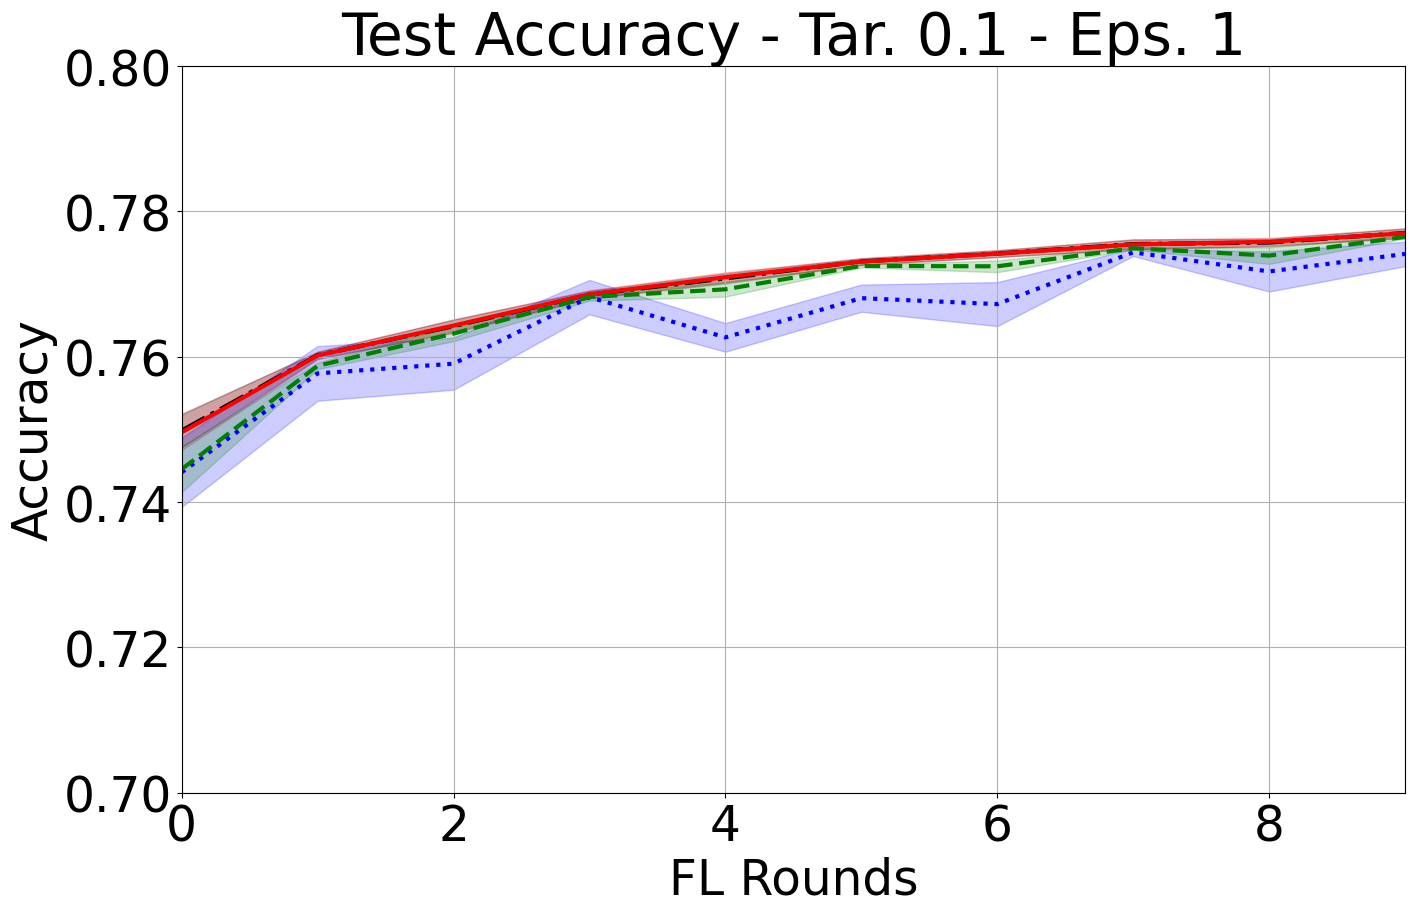

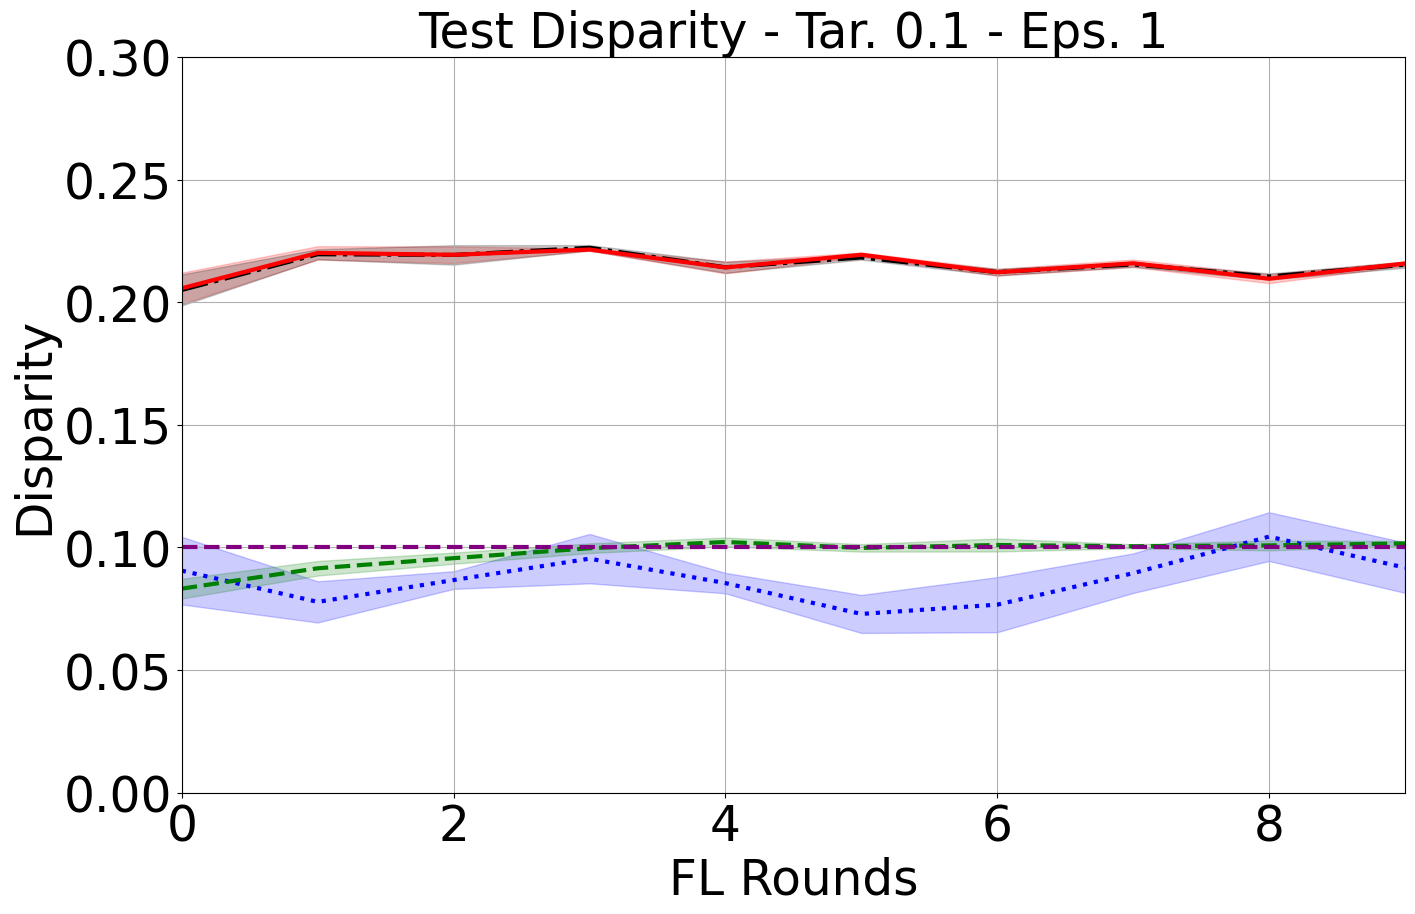

<Figure size 640x480 with 0 Axes>

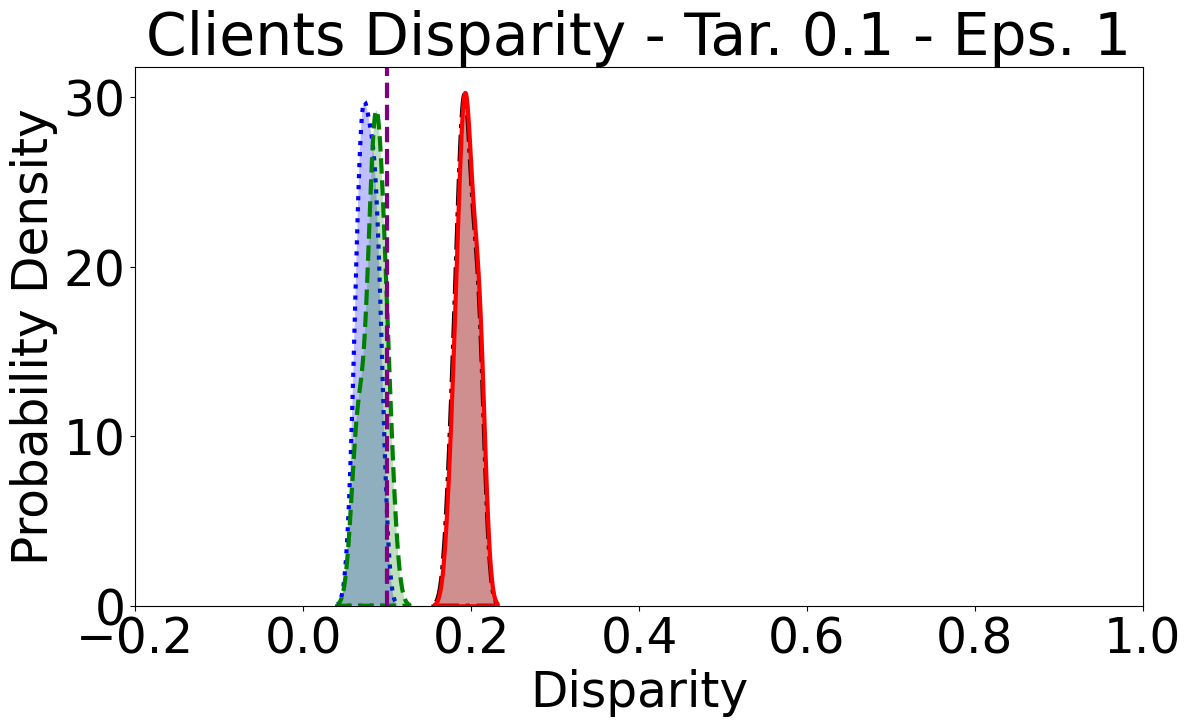

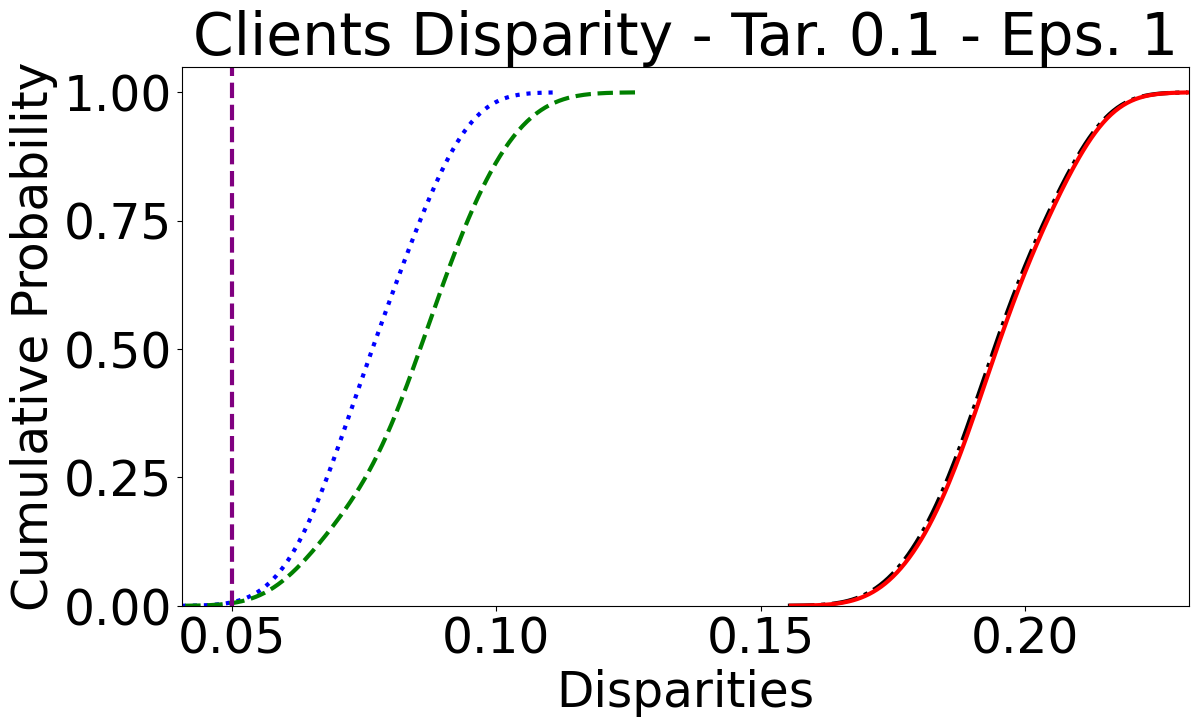

target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.1 & 1 & 0.7770290241583374+-0.0006569594577199506 & 0.7769792696630397+-0.0006415684919610365, 0.7764863628409817+-0.00021069232633159324, 0.7741365170588347+-0.0016887324386713621
target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.1 & 1 & 0.2153057533796293+-0.0012281347408334674 & 0.21577786723927064+-0.000898189538180328, 0.10163433471318739+-0.0009743245463194466, 0.09177019374110126+-0.010277608745266207


In [121]:
plot(
    experiment_type="Test",
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
    target=0.1,
    epsilon=1,
    no_dp="Income_Baseline_no_dp",
    baseline="Income_Baseline_1",
    fixed="Income_01_epsilon_1_fixed",
    tunable="Income_01_epsilon_1_tunable", #"Celeba_003_epsilon_5_tunable",
)

In [122]:
# plot_no_dp(
#     experiment_type="Test",
#     disparity_experiments_type="Test Disparity with statistics",
#     target=0.0375,
#     fixed="Celeba_003_no_dp_fixed",
#     tunable="Celeba_003_no_dp_tunable",
# )

# Target 0.075 - Epsilon 1

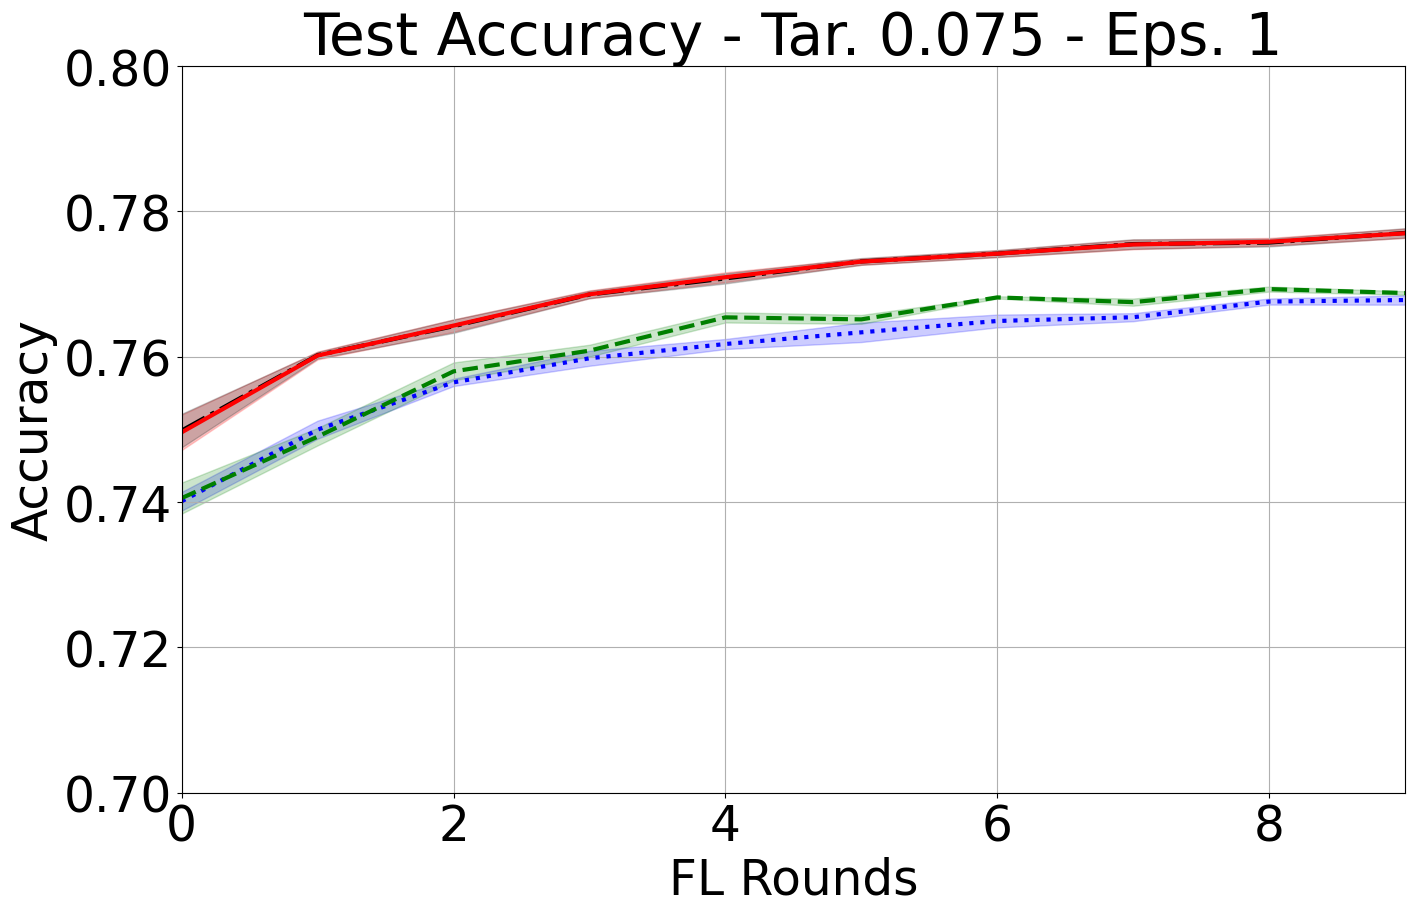

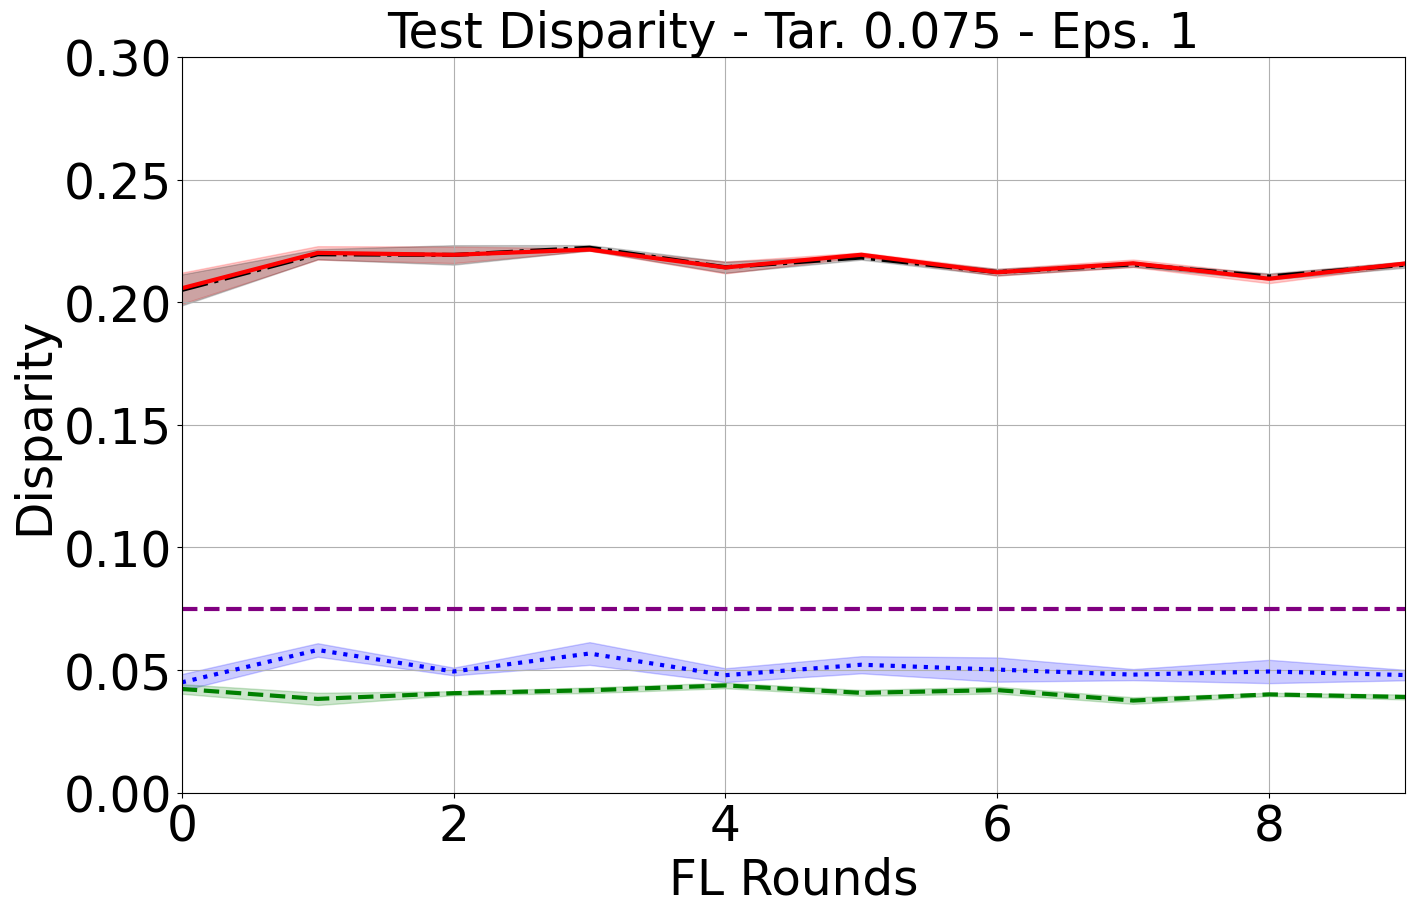

<Figure size 640x480 with 0 Axes>

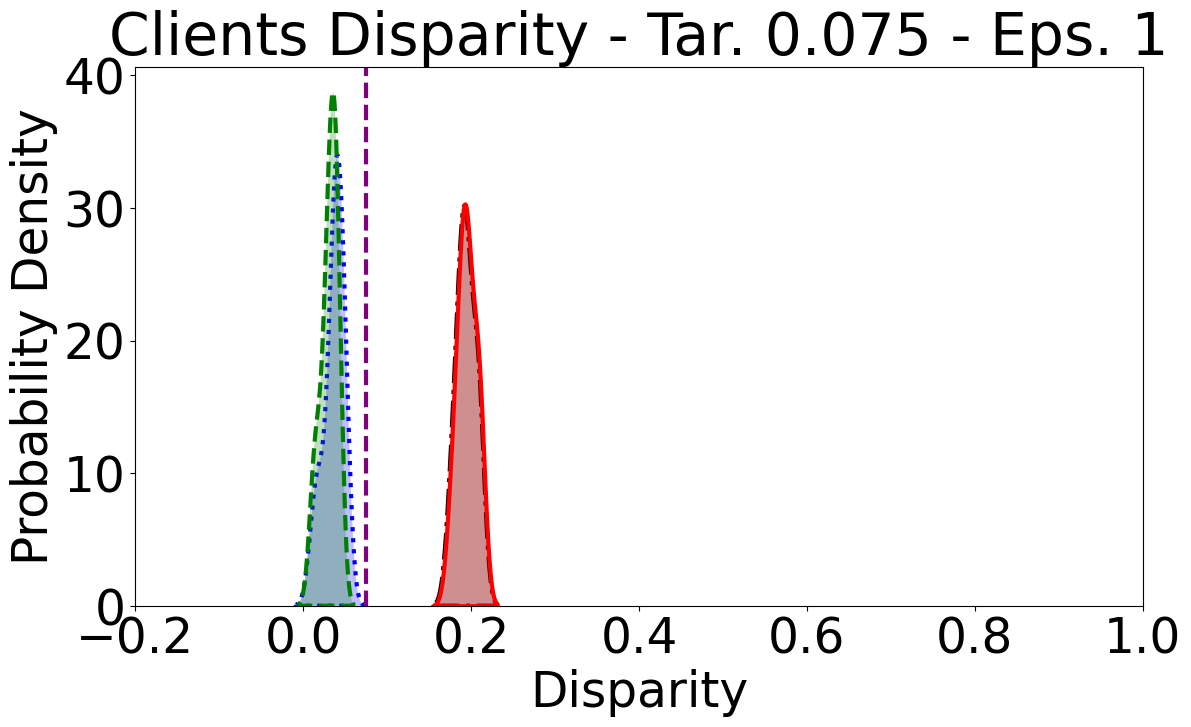

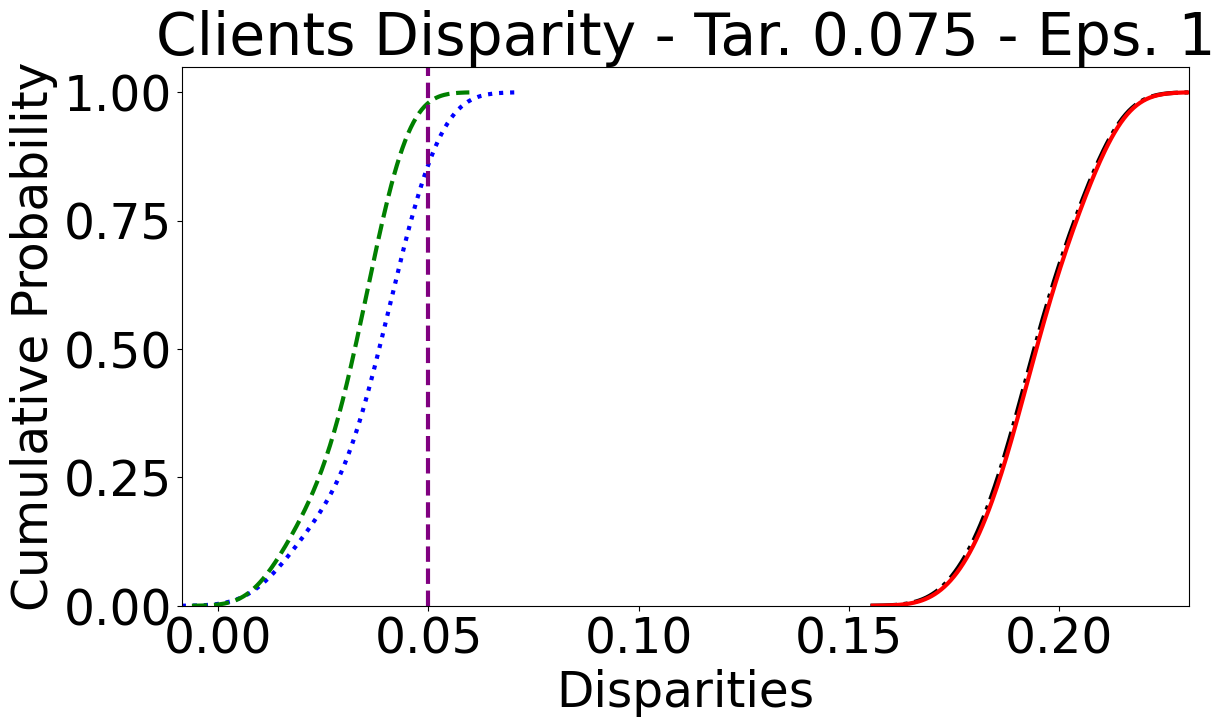

target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.075 & 1 & 0.7770290241583374+-0.0006569594577199506 & 0.7769792696630397+-0.0006415684919610365, 0.7687609233253712+-0.0002475892260295095, 0.7677953487979862+-0.0006395115066327829
target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.075 & 1 & 0.2153057533796293+-0.0012281347408334674 & 0.21577786723927064+-0.000898189538180328, 0.03903977470304658+-0.0009982137714367948, 0.04798652649516193+-0.002146186366944625


In [123]:
plot(
    experiment_type="Test",
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
    target=0.075,
    epsilon=1,
    no_dp="Income_Baseline_no_dp",
    baseline="Income_Baseline_1",
    fixed="Income_0075_epsilon_1_fixed",
    tunable="Income_0075_epsilon_1_tunable", #"Celeba_005_epsilon_5_tunable",
)

In [124]:
# plot_no_dp(
#     experiment_type="Test",
#     disparity_experiments_type="Test Disparity with statistics",
#     target=0.05,
#     fixed="Celeba_005_no_dp_fixed",
#     tunable="Celeba_005_no_dp_tunable",
# )

# Target 0.05 - Epsilon 1

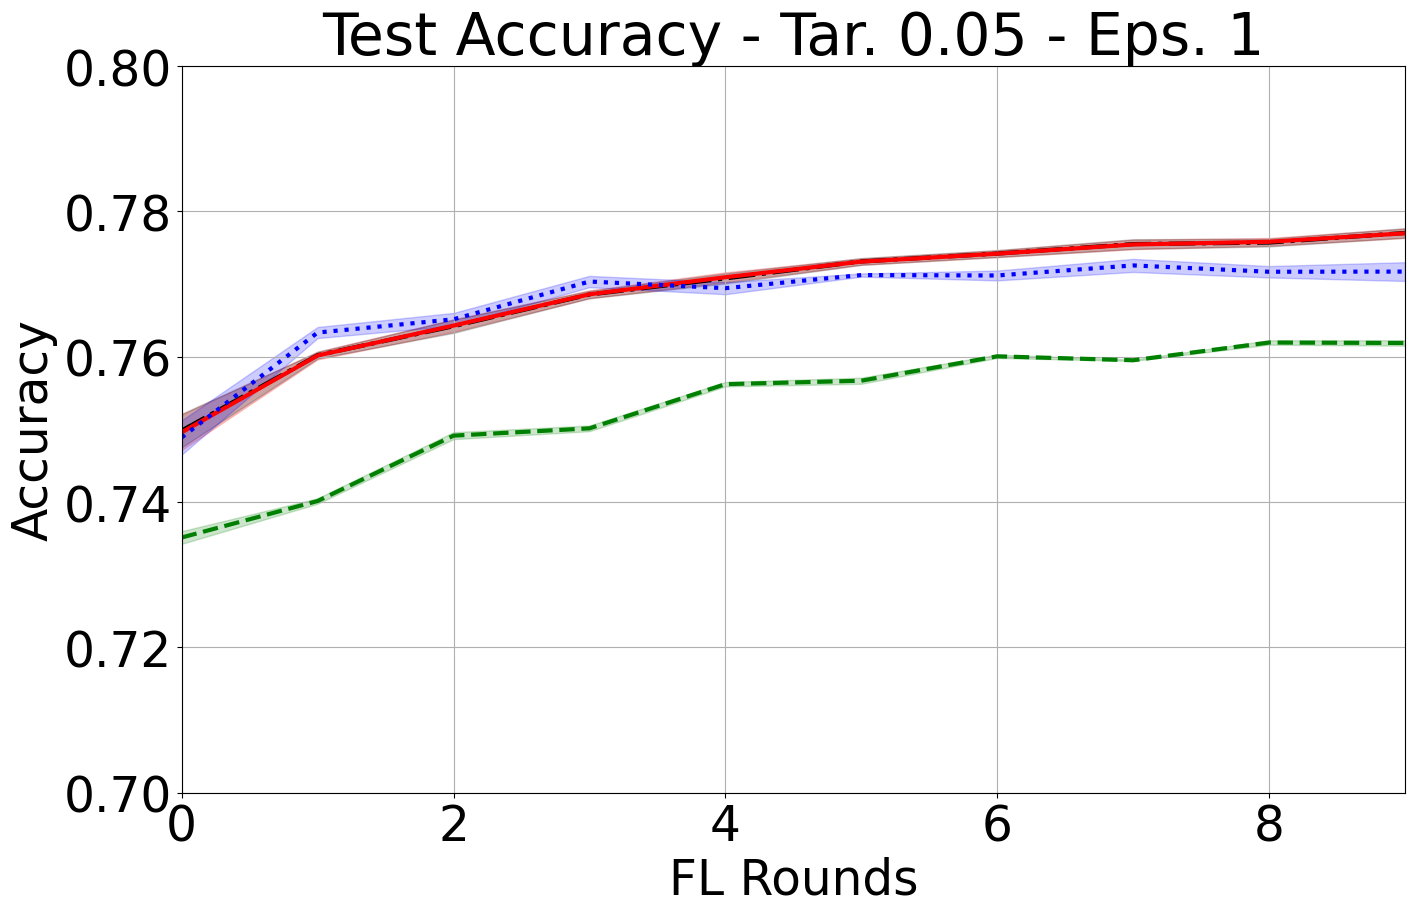

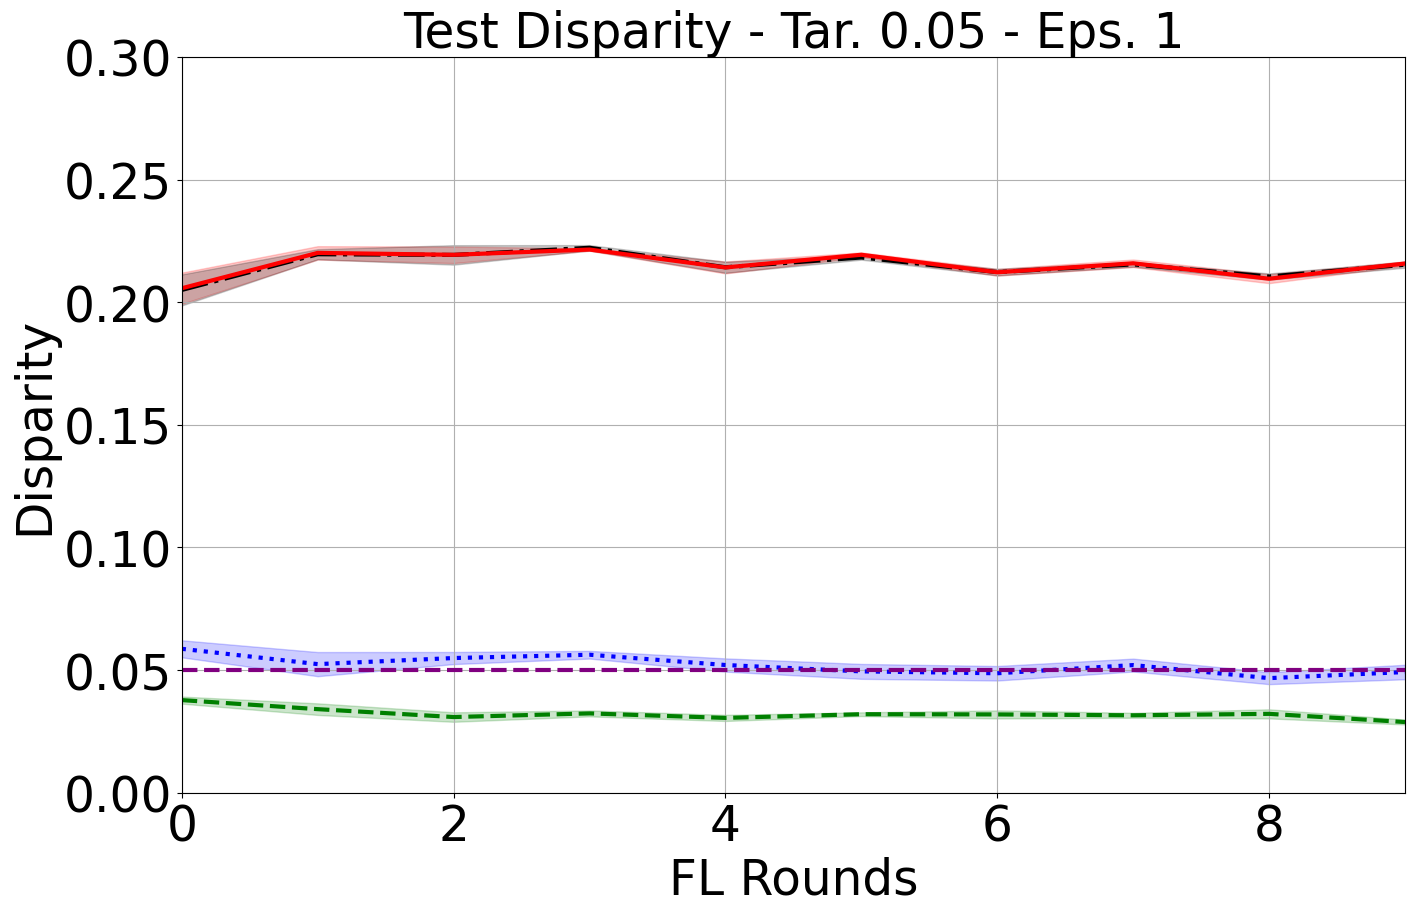

<Figure size 640x480 with 0 Axes>

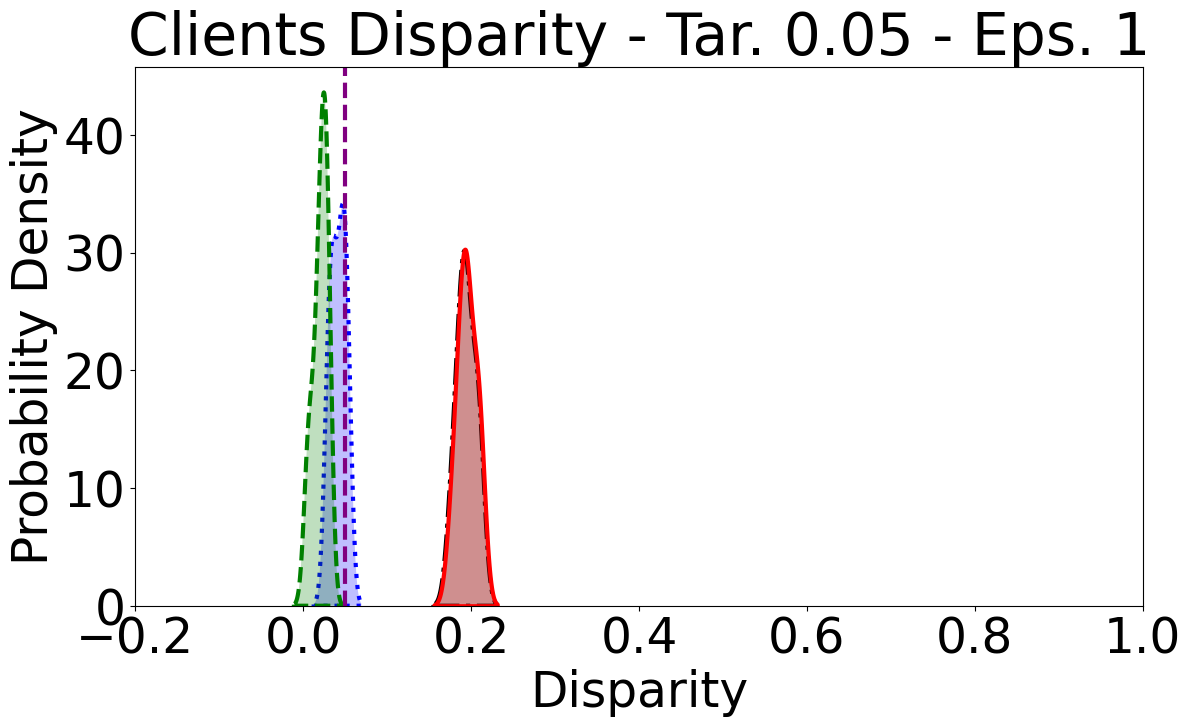

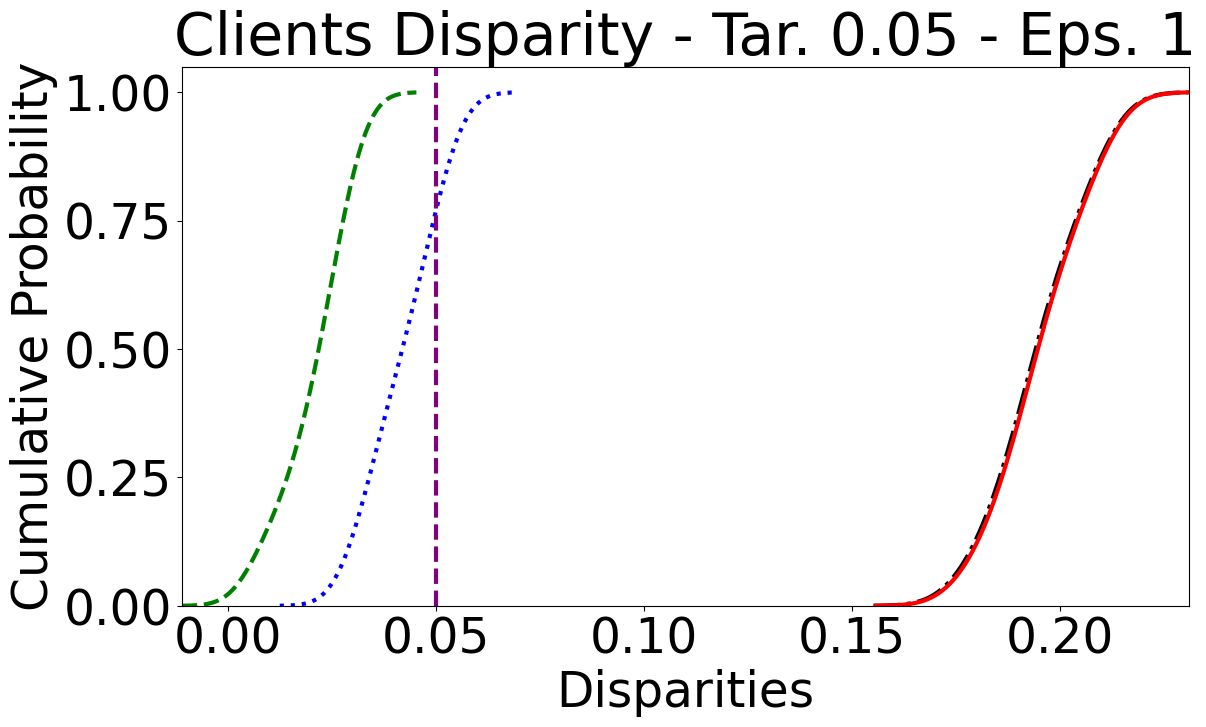

target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.05 & 1 & 0.7770290241583374+-0.0006569594577199506 & 0.7769792696630397+-0.0006415684919610365, 0.7618872133055328+-0.00037330245243155267, 0.7717086663476195+-0.0012934527708384157
target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.05 & 1 & 0.2153057533796293+-0.0012281347408334674 & 0.21577786723927064+-0.000898189538180328, 0.028825552697362887+-0.0009970702307754925, 0.04921394213784236+-0.002950304543827947


In [125]:
plot(
    experiment_type="Test",
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
    target=0.05,
    epsilon=1,
    no_dp="Income_Baseline_no_dp",
    baseline="Income_Baseline_1",
    fixed="Income_005_epsilon_1_fixed",
    tunable="Income_005_epsilon_1_tunable",
)

In [126]:
# plot_no_dp(
#     experiment_type="Test",
#     disparity_experiments_type="Test Disparity with statistics",
#     target=0.075,
#     fixed="Celeba_007_no_dp_fixed",
#     tunable="Celeba_007_no_dp_tunable",
# )

# Target 0.1 Epsilon 2

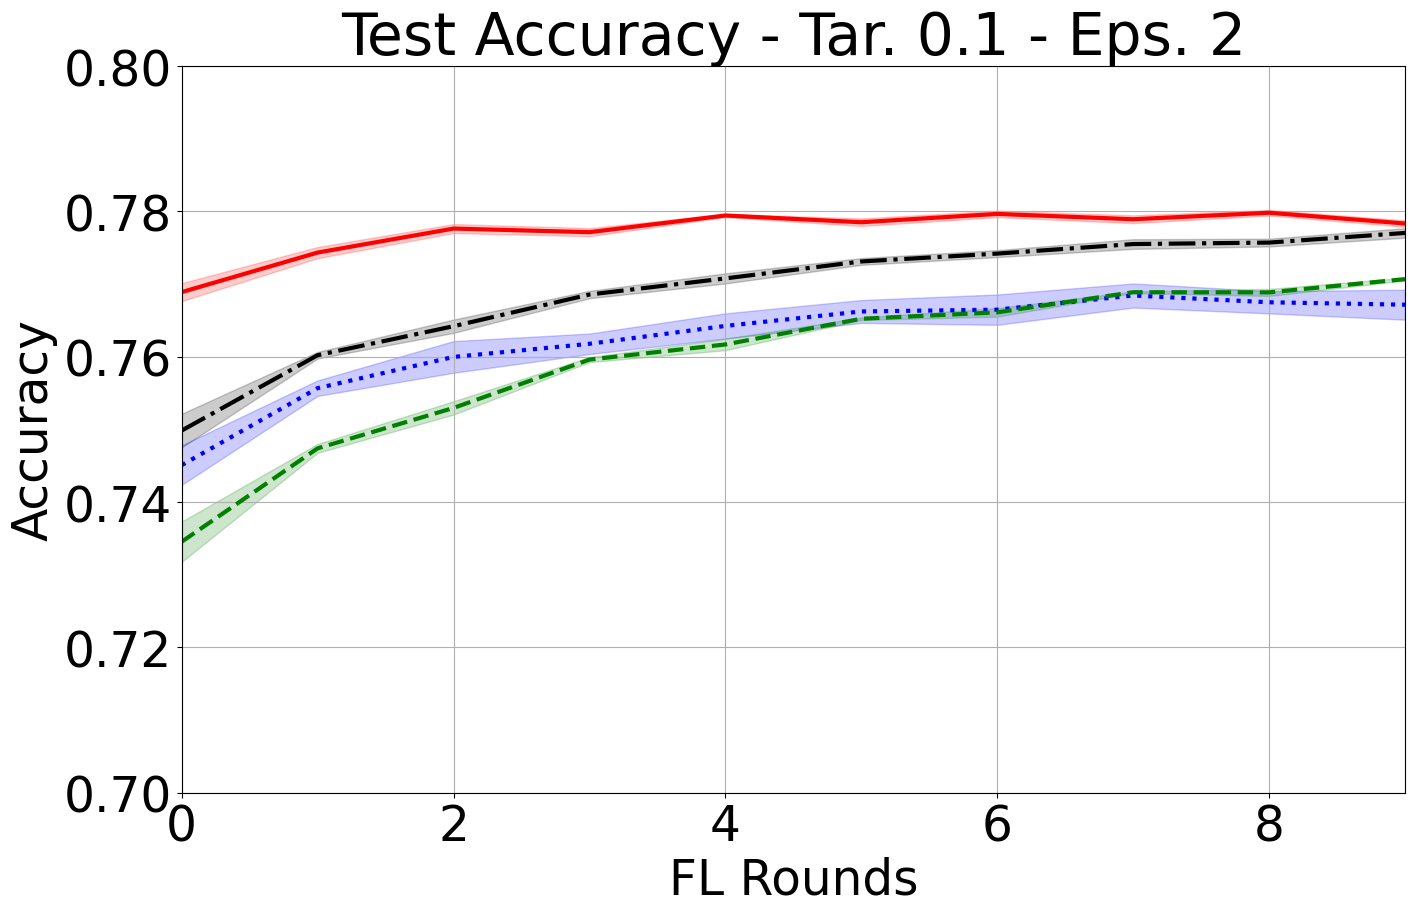

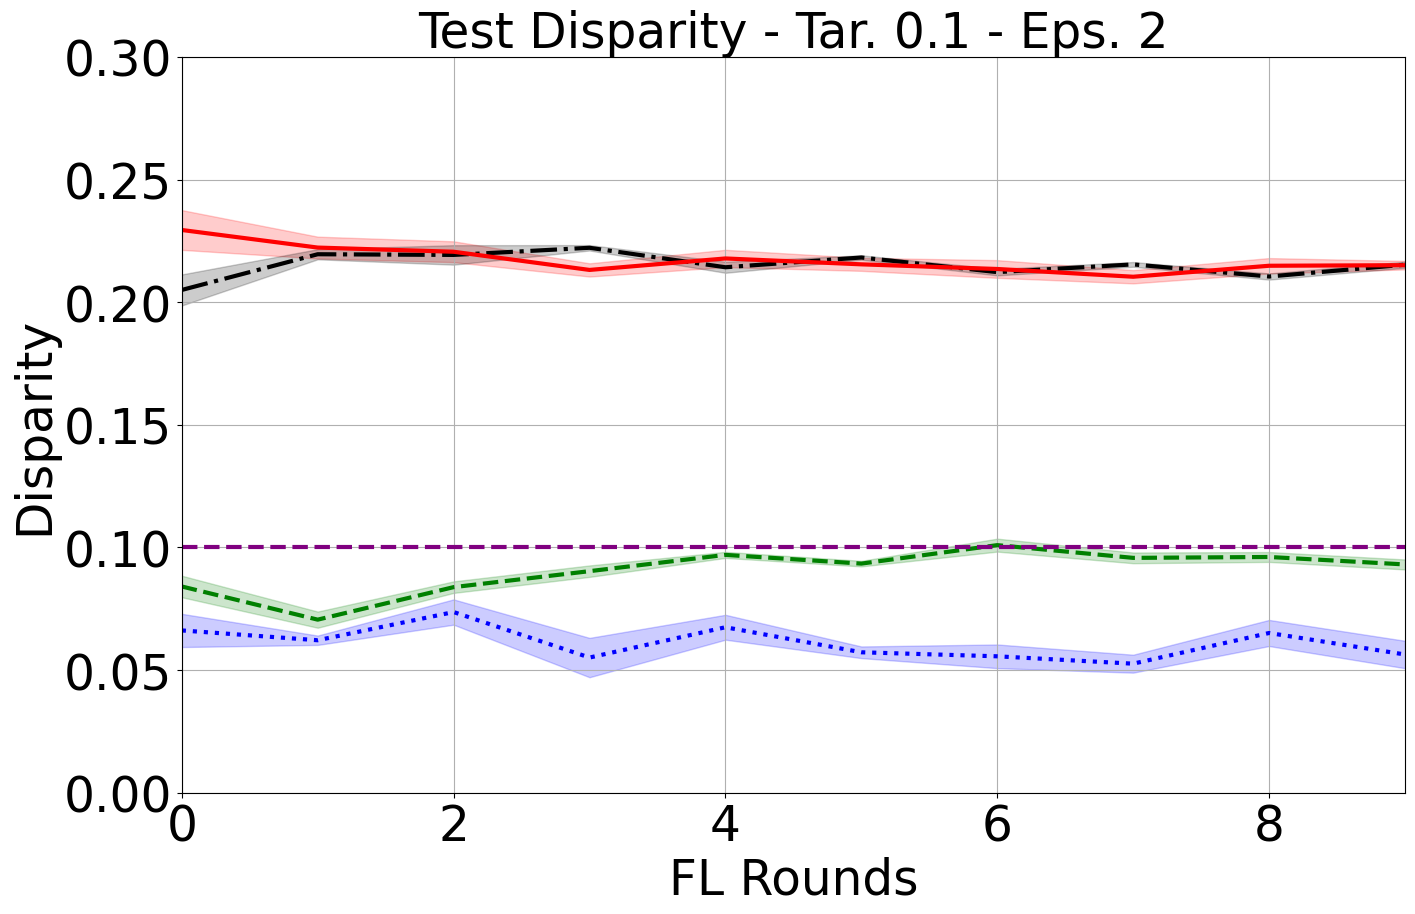

<Figure size 640x480 with 0 Axes>

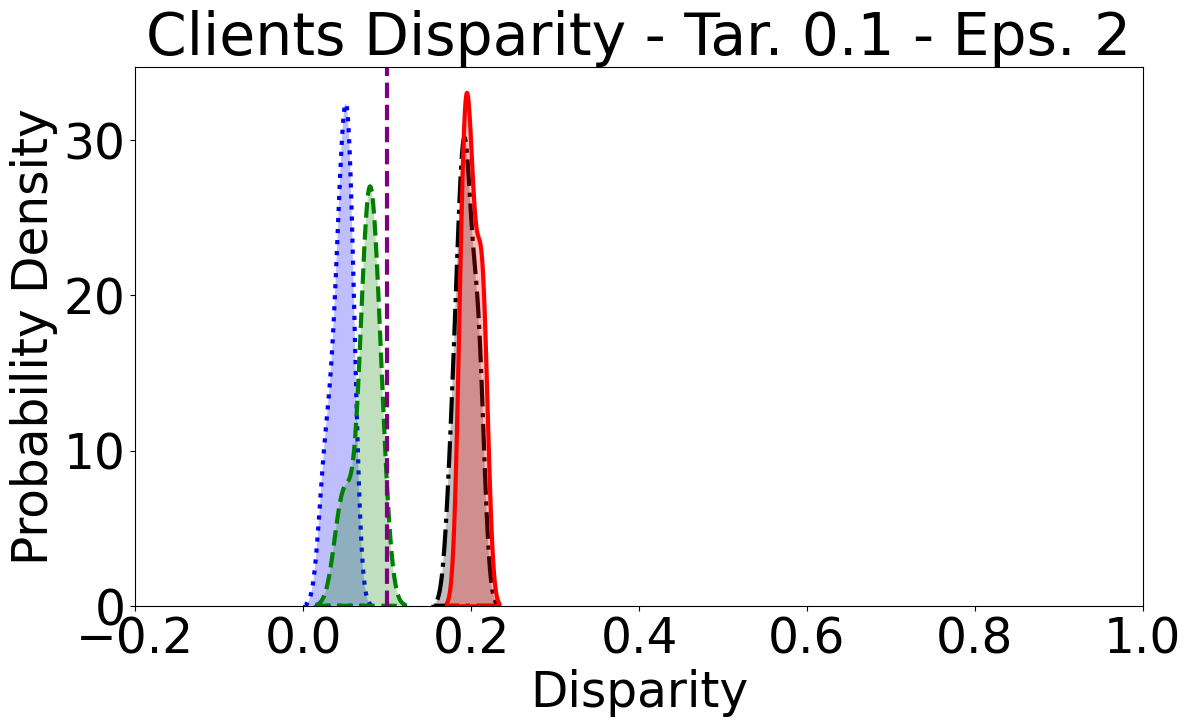

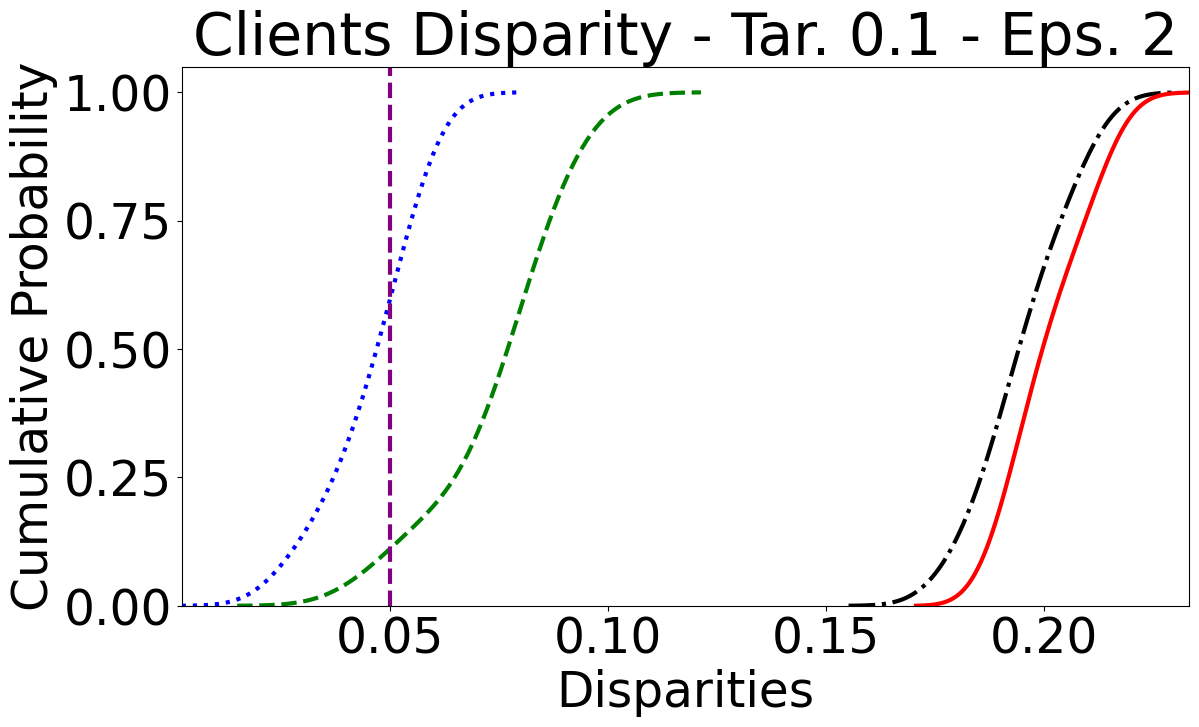

target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.1 & 2 & 0.7770290241583374+-0.0006569594577199506 & 0.7783277008152569+-0.00044304509637624275, 0.7706722549116752+-0.00019586163292947774, 0.7671552867313615+-0.0020619034532043533
target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.1 & 2 & 0.2153057533796293+-0.0012281347408334674 & 0.21510994067512962+-0.001731186071980517, 0.09308553245209242+-0.0020366257848920817, 0.056363147068932654+-0.005589790448051839


In [127]:
plot(
    experiment_type="Test",
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
    target=0.1,
    epsilon=2,
    no_dp="Income_Baseline_no_dp",
    baseline="Income_Baseline_2",
    fixed="Income_01_epsilon_2_fixed",
    tunable="Income_01_epsilon_2_tunable",
)

# Target 0.075 Epsilon 2

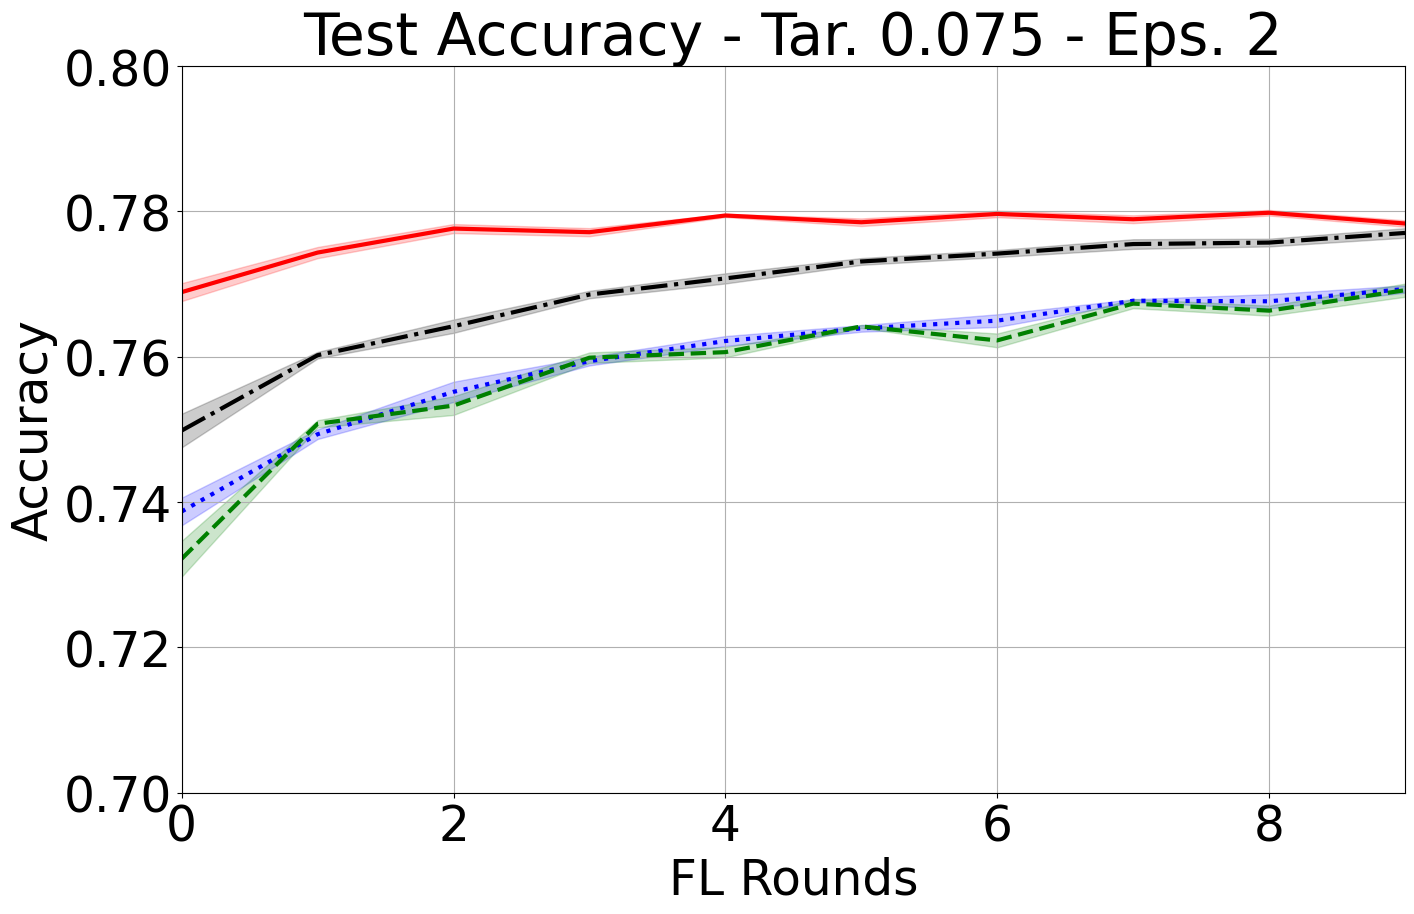

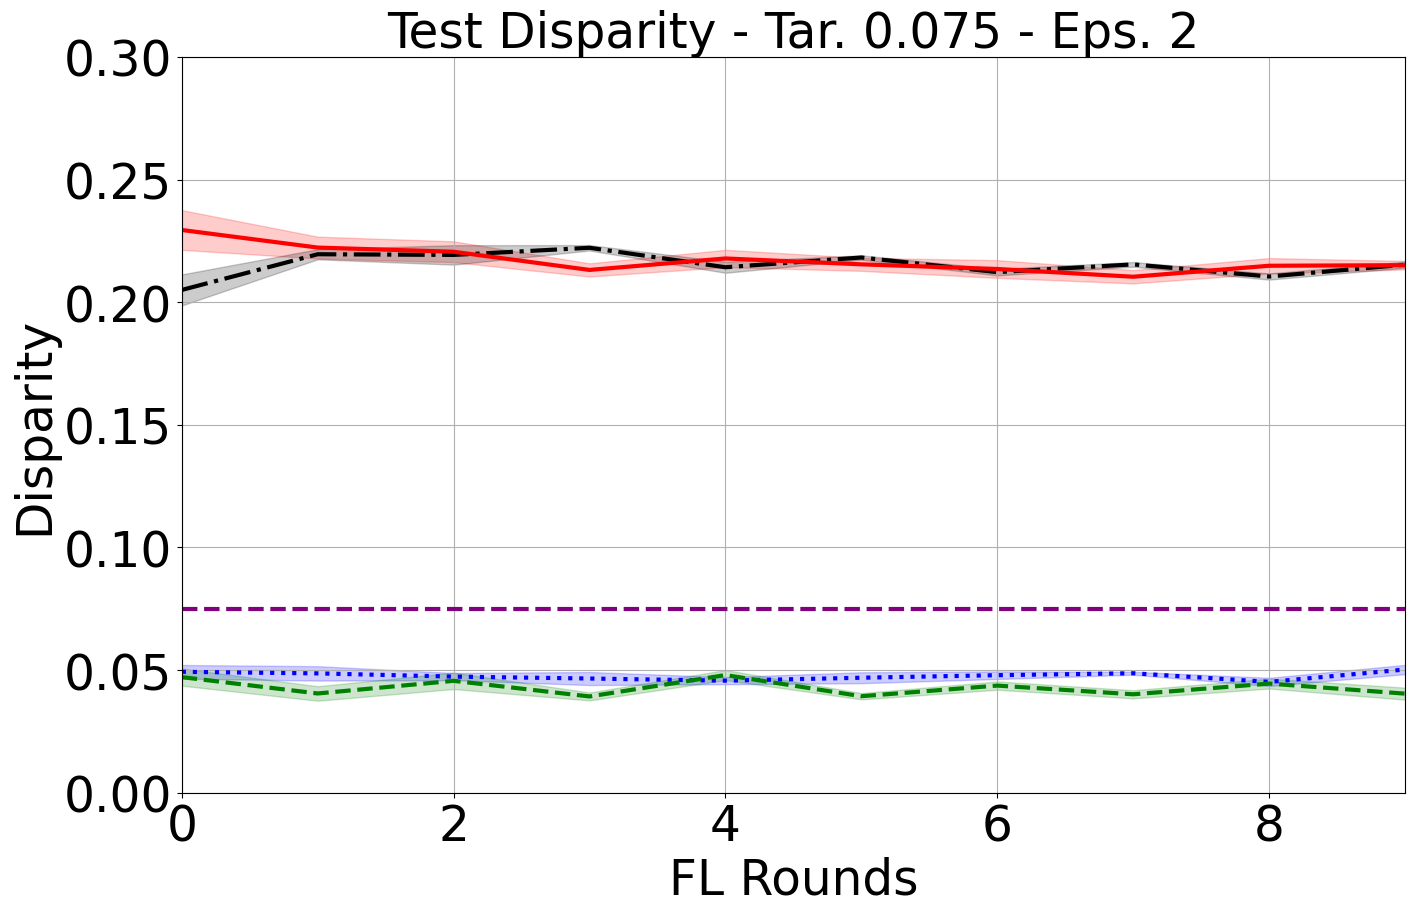

<Figure size 640x480 with 0 Axes>

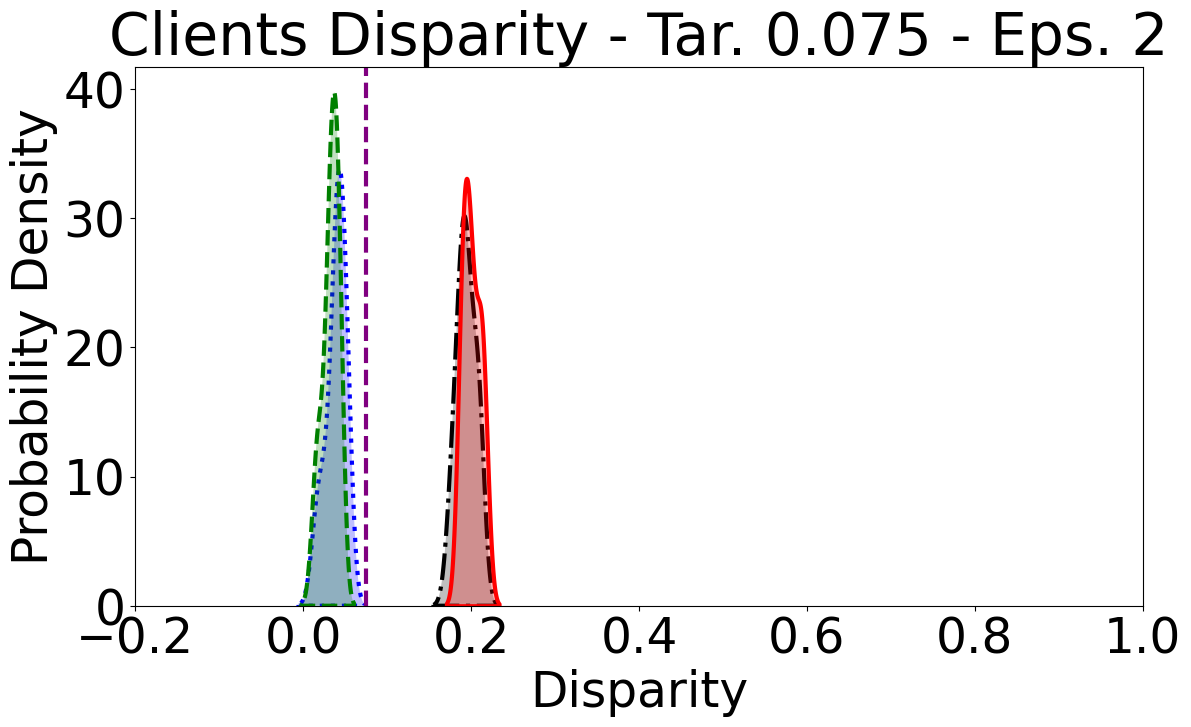

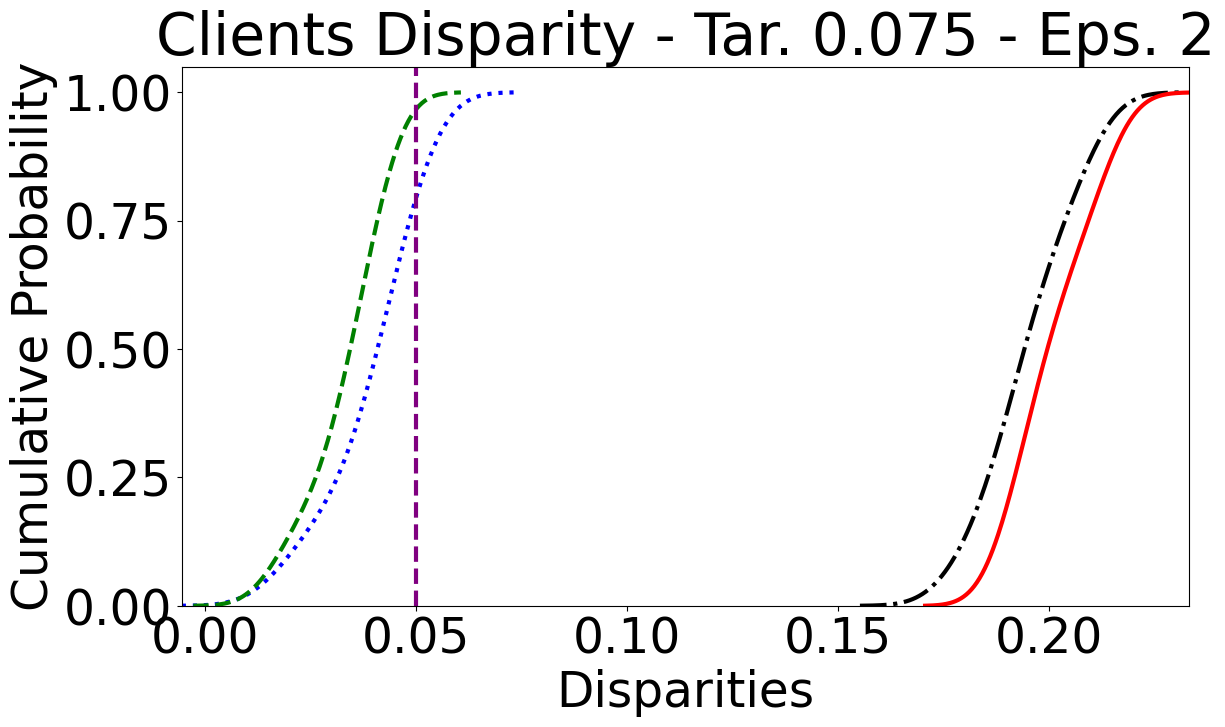

target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.075 & 2 & 0.7770290241583374+-0.0006569594577199506 & 0.7783277008152569+-0.00044304509637624275, 0.7691442015984686+-0.0009057493015517933, 0.7693082227736445+-0.0004948129973134337
target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.075 & 2 & 0.2153057533796293+-0.0012281347408334674 & 0.21510994067512962+-0.001731186071980517, 0.040403001614429015+-0.0024461967679976202, 0.05024318200957847+-0.0018928538458222544


In [128]:
plot(
    experiment_type="Test",
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
    target=0.075,
    epsilon=2,
    no_dp="Income_Baseline_no_dp",
    baseline="Income_Baseline_2",
    fixed="Income_0075_epsilon_2_fixed", #"Celeba_005_epsilon_8_fixed",
    tunable="Income_0075_epsilon_2_tunable", #"Celeba_005_epsilon_8_tunable",
)

# Target 0.05 Epsilon 2

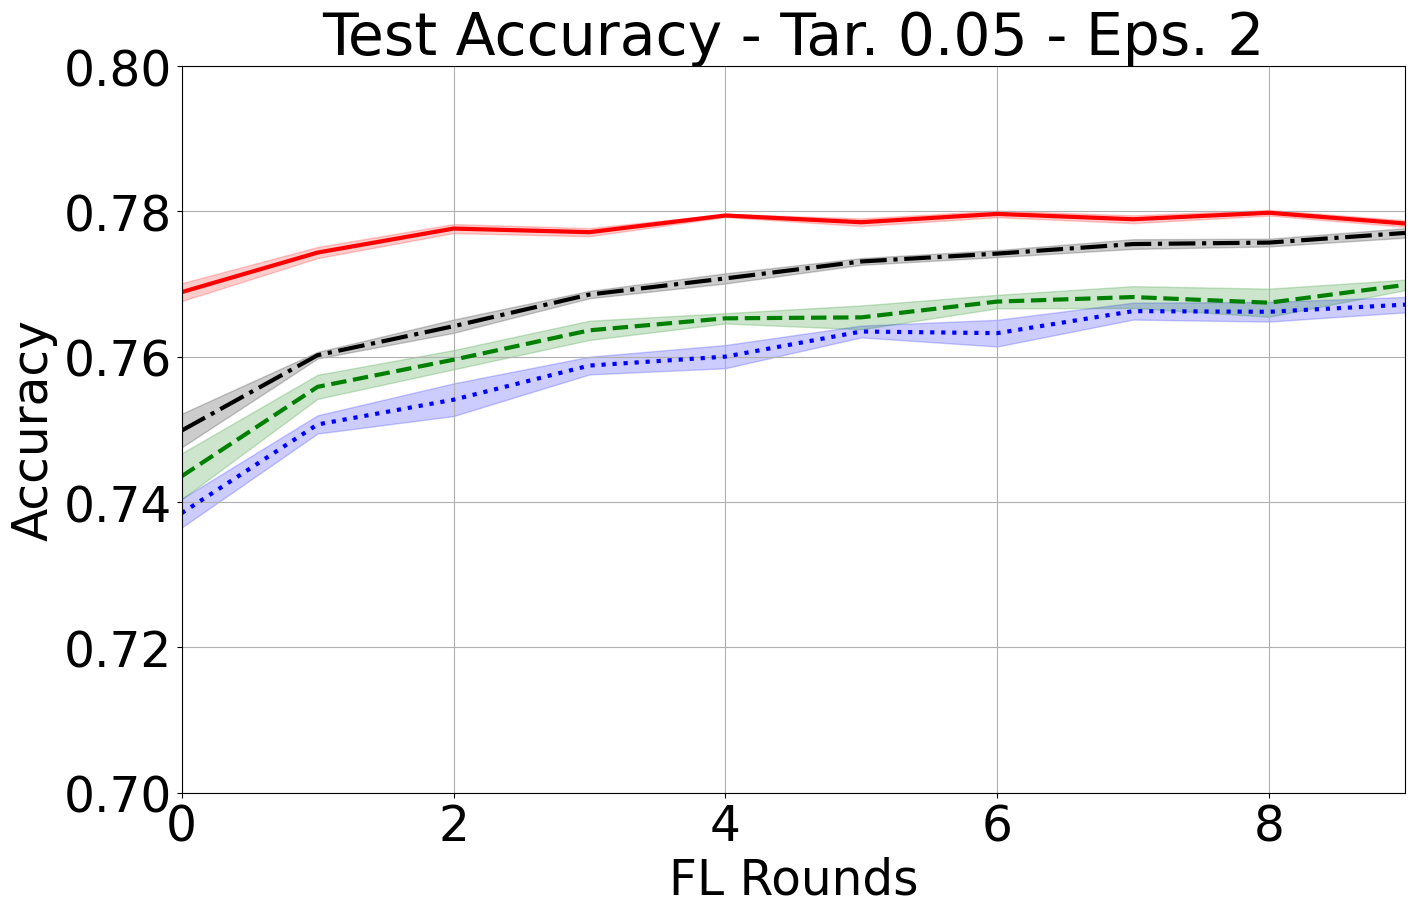

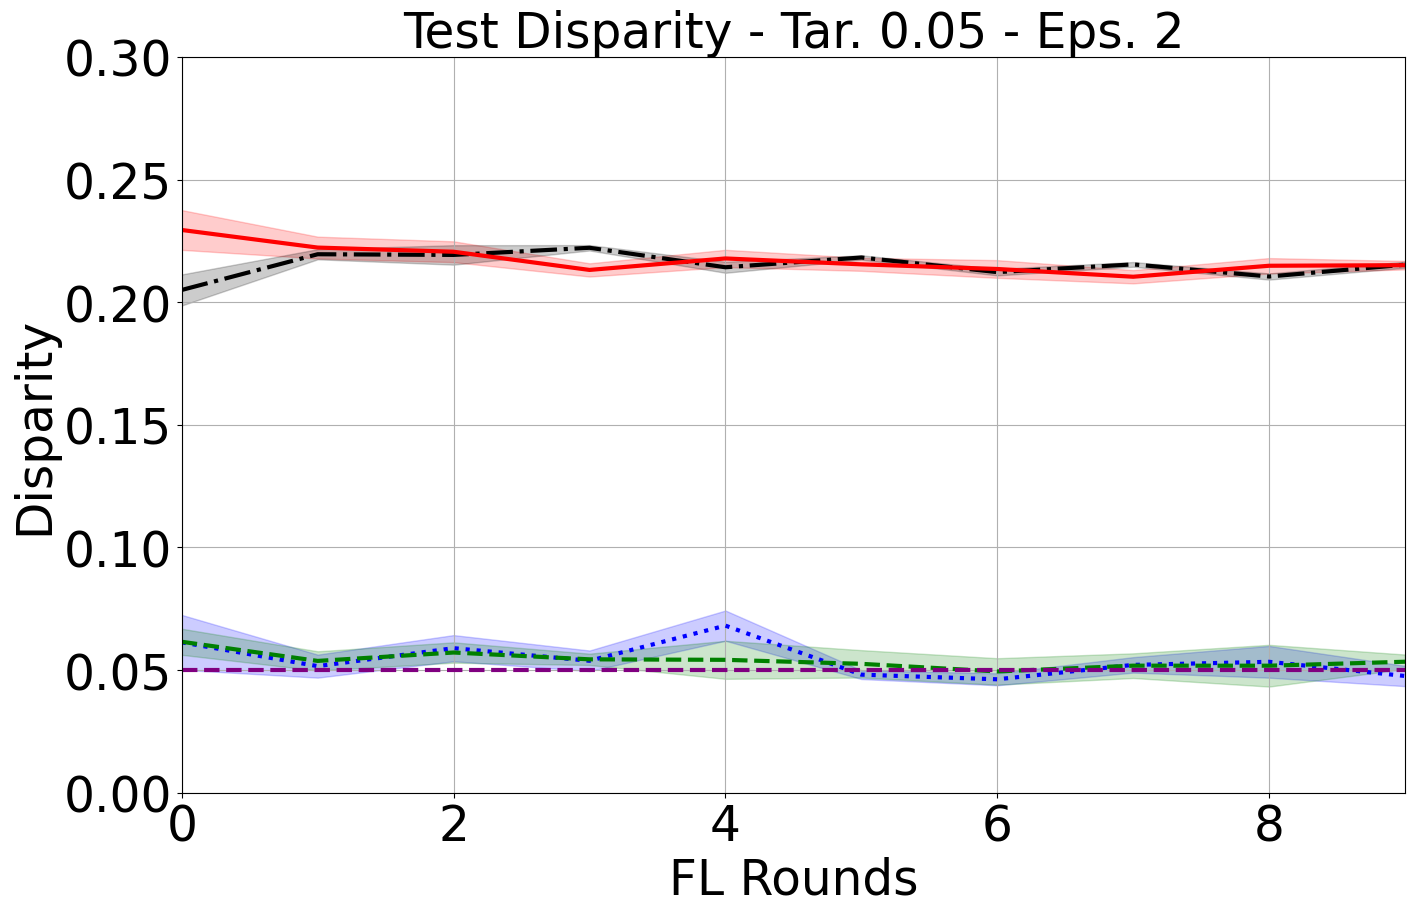

<Figure size 640x480 with 0 Axes>

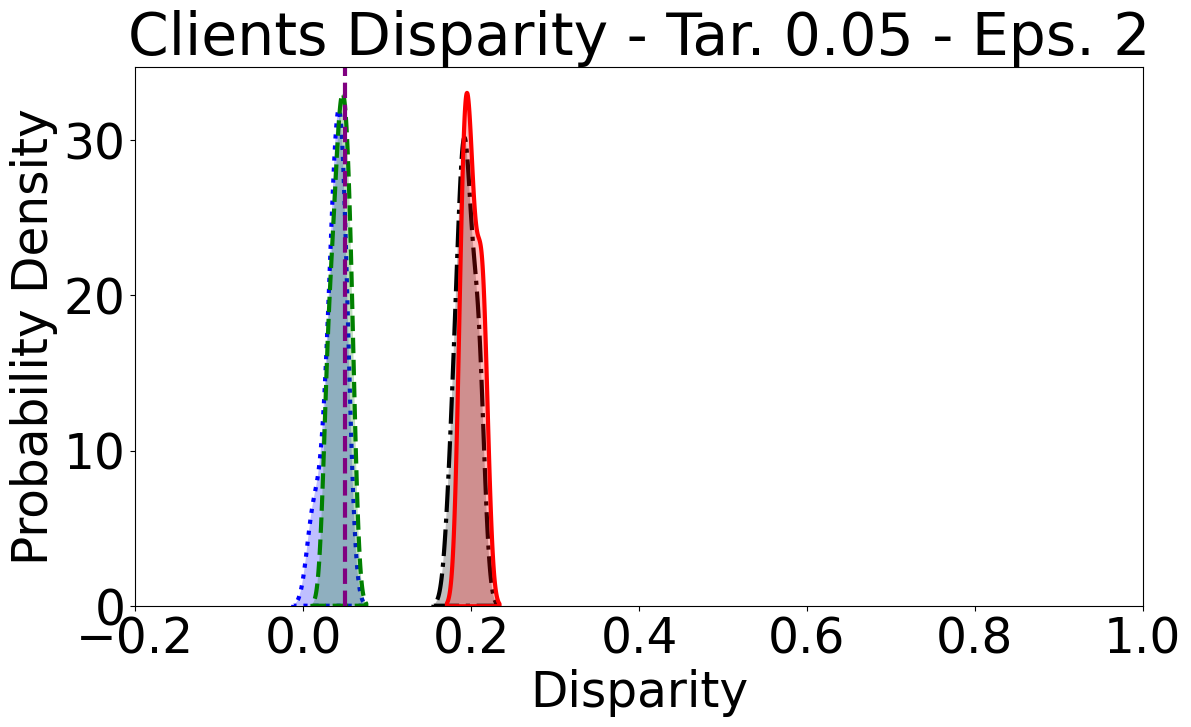

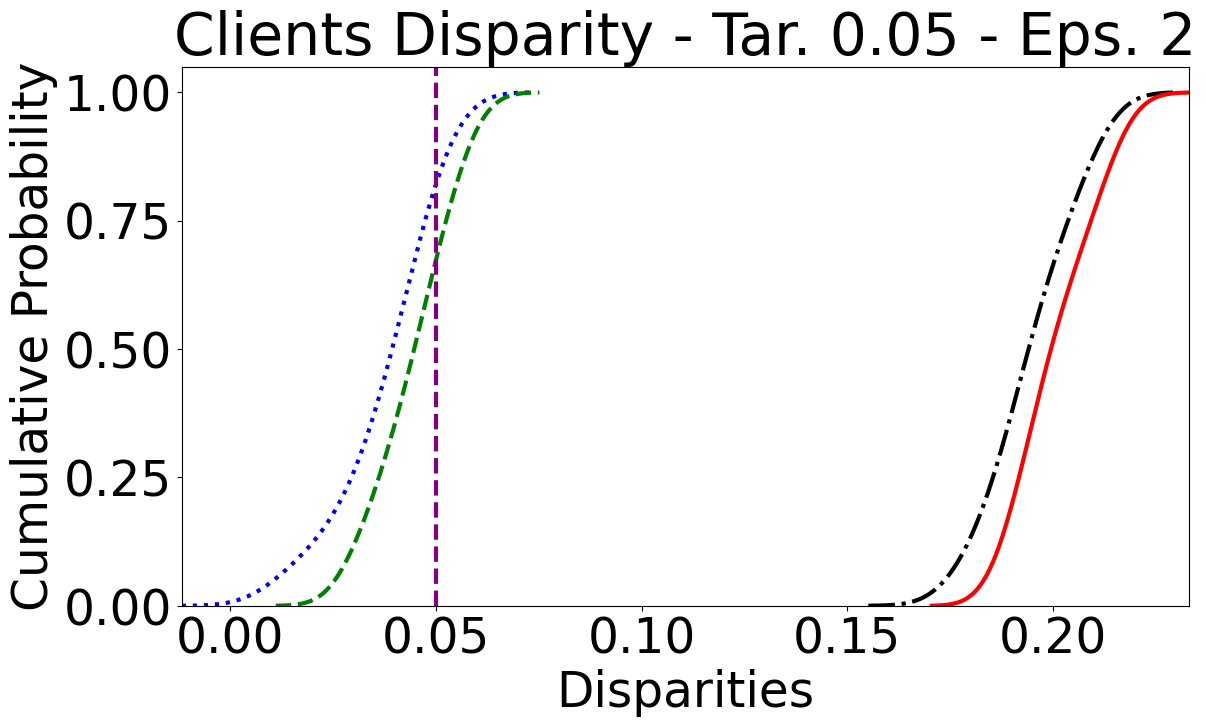

target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.05 & 2 & 0.7770290241583374+-0.0006569594577199506 & 0.7783277008152569+-0.00044304509637624275, 0.769874074745588+-0.0007212476913220631, 0.7671586599174833+-0.001062505648083202
target & epsilon & no_dp_mean[0]+-no_dp_sem[0] & baseline_mean[0]+-baseline_sem[0], fixed_mean[0]+-fixed_sem[0], tunable_mean[0]+-tunable_sem[0]
0.05 & 2 & 0.2153057533796293+-0.0012281347408334674 & 0.21510994067512962+-0.001731186071980517, 0.053417473016012816+-0.002937297475223115, 0.04760388577876394+-0.004142610021238642


In [129]:
plot(
    experiment_type="Test",
    accuracy_experiments_type="Test Accuracy",
    disparity_experiments_type="Test Disparity with statistics",
    target=0.05,
    epsilon=2,
    no_dp="Income_Baseline_no_dp",
    baseline="Income_Baseline_2",
    fixed="Income_005_epsilon_2_fixed", #"Celeba_007_epsilon_8_fixed",
    tunable="Income_005_epsilon_2_tunable" #"Celeba_007_epsilon_8_tunable",
)